---
# **[Fraud Detection System (FDS) – Comprehensive EDA & Feature Engineering]** 
---

In [86]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.metrics import average_precision_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    classification_report
)
pd.set_option("display.max_rows", None)
LABEL = "fraud"

%matplotlib inline

In [20]:
df = pd.read_parquet("DATA/dataset/train_stage2")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312525 entries, 0 to 5332978
Data columns (total 53 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

In [22]:
df.shape

(5312525, 53)

---

# **Static Risk Feature Analysis**

## Demographic & Financial Features
- current_age
- yearly_income
- total_debt
- credit_score
- credit_limit
- amount
- amount_income_ratio
- amount_limit_ratio

### current_age

In [32]:
df["current_age"].describe()

count    5.312525e+06
mean     5.423151e+01
std      1.561813e+01
min      2.300000e+01
25%      4.300000e+01
50%      5.200000e+01
75%      6.300000e+01
max      1.010000e+02
Name: current_age, dtype: float64

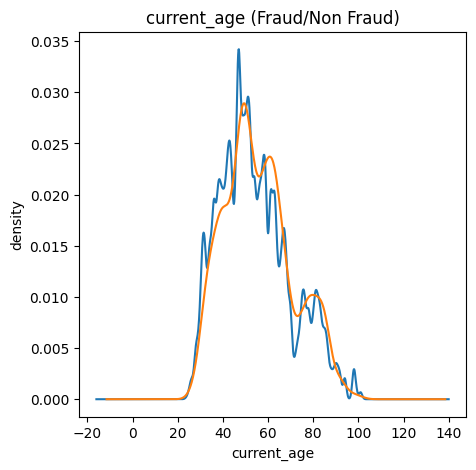

In [35]:
plt.figure(figsize=(5,5))
df[df["fraud"]==0]["current_age"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"]==1]["current_age"].plot(kind="kde", label="Fraud")
plt.xlabel("current_age")
plt.title("current_age (Fraud/Non Fraud)")
plt.ylabel("density")
plt.show()

### yearly_income

In [13]:
df["yearly_income"].describe()

count    5.312525e+06
mean     4.677138e+04
std      2.444741e+04
min      1.000000e+00
25%      3.281700e+04
50%      4.109100e+04
75%      5.401300e+04
max      2.801990e+05
Name: yearly_income, dtype: float64

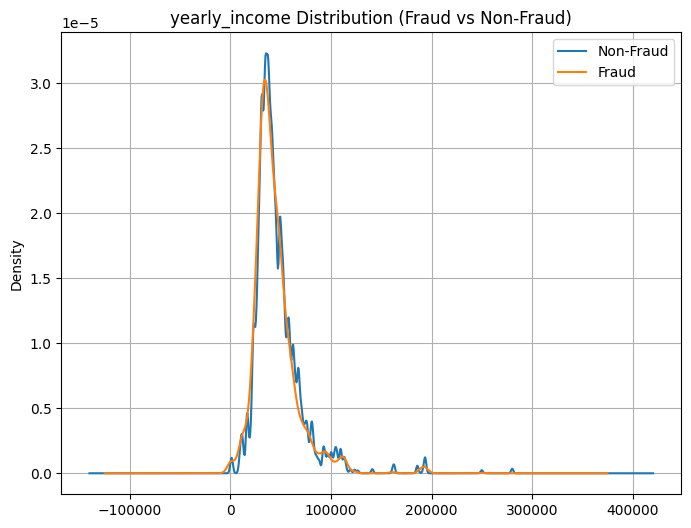

In [14]:
plt.figure(figsize=(8,6))
df[df["fraud"]==0]["yearly_income"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"]==1]["yearly_income"].plot(kind="kde", label="Fraud")
plt.title("yearly_income Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df["yearly_income"].value_counts().sort_index()

yearly_income
1.0          2248
2.0           247
4.0            12
399.0         960
553.0         845
645.0        1601
920.0        2709
1426.0       7930
1785.0       1821
2365.0       2331
8526.0       3223
9678.0       3345
9766.0       7674
9795.0       3389
10142.0      3077
10869.0      6762
11029.0      4131
11410.0      5886
11566.0      6223
11613.0      4450
12044.0      8451
12796.0      4093
12826.0      3336
13089.0      3449
13596.0      2289
15348.0      6326
15470.0      4797
16302.0      4956
16342.0      4130
16430.0      4796
16542.0      3208
16611.0      3156
16620.0      4561
16628.0      2867
16646.0      8212
16889.0      1974
17016.0      4620
17056.0      3997
17078.0      8562
17150.0      3694
17657.0      1411
18015.0      2121
18100.0      5333
18149.0       870
18452.0      2190
19199.0      1770
19225.0      5012
19581.0      2485
19682.0      3470
19800.0      1513
19893.0      3211
20377.0      1597
20424.0      3488
20577.0      4925
20614.0      1

In [17]:
low_vals = [1,0, 2.0, 4.0, 399.0, 553.0, 645.0, 920.0, 1426.0]

(df[df["yearly_income"].isin(low_vals)]
 .groupby("yearly_income")["fraud"]
 .agg(["count","mean"])
 .sort_index())

,count,mean
yearly_income,,
1.0,2248,0.000000
2.0,247,0.000000
4.0,12,0.166667
399.0,960,0.031250
553.0,845,0.007101
645.0,1601,0.003123
920.0,2709,0.002215
1426.0,7930,0.000000


In [16]:
(df[df["yearly_income"].isin([1.0, 4.0])]
 .groupby("yearly_income")[["per_capita_income","credit_limit","credit_score"]]
 .describe())

per_capita_income                                     \
                          count mean  std  min  25%  50%  75%  max   
yearly_income                                                        
1.0                      2248.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4.0                        12.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              credit_limit            ...             credit_score         \
                     count      mean  ...   75%   max        count   mean   
yearly_income                         ...                                   
1.0                 2248.0  49.86121  ...  81.0  81.0       2248.0  673.0   
4.0                   12.0   1.00000  ...   1.0   1.0         12.0  691.0   

                                                       
               std    min    25%    50%    75%    max  
yearly_income                                          
1.0            0.0  673.0  673.0  673.0  673.0  673.0  
4.0            0.0  691.0  691.0  691.0  691.0  691.0  

[2 rows x 24 columns]

In [23]:
df["low_income_flag"] = (df["yearly_income"] < 1000).astype("int8")

> 비현실적인 연소득이 존재해서 flag 필요

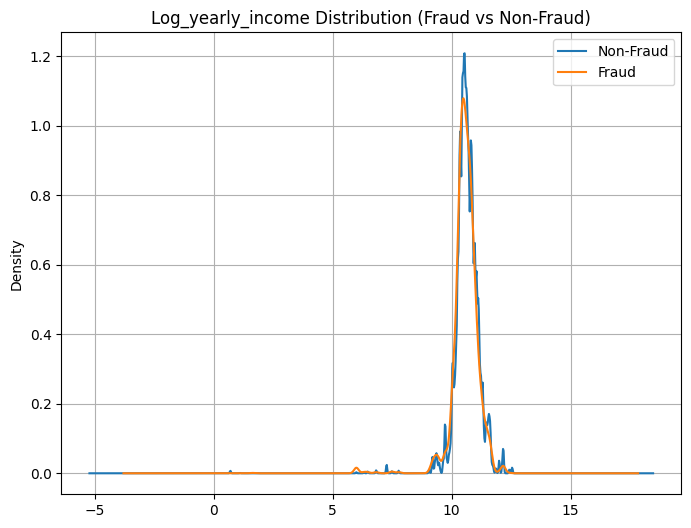

In [31]:
plt.figure(figsize=(8,6))
df[df["fraud"]==0]["log_yearly_income"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"]==1]["log_yearly_income"].plot(kind="kde", label="Fraud")
plt.title("Log_yearly_income Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

### total_debt

In [25]:
df["total_debt"].describe()

count    5.312525e+06
mean     5.798938e+04
std      5.194811e+04
min      0.000000e+00
25%      1.652400e+04
50%      5.167900e+04
75%      8.516000e+04
max      4.618540e+05
Name: total_debt, dtype: float64

In [26]:
non = df[df["fraud"]==0].copy()
fraud = df[df["fraud"]==1].copy()

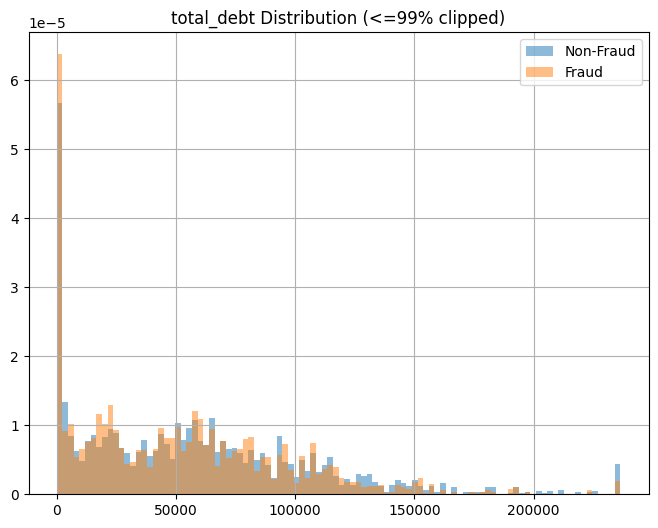

In [28]:
col = "total_debt"

non = df.loc[df["fraud"] == 0, col].dropna()
fraud = df.loc[df["fraud"] == 1, col].dropna()

xmax = df[col].quantile(0.99)
non = non.clip(upper=xmax)
fraud = fraud.clip(upper=xmax)

plt.figure(figsize=(8,6))
plt.hist(non, bins=100, alpha=0.5, label="Non-Fraud", density=True)
plt.hist(fraud, bins=100, alpha=0.5, label="Fraud", density=True)
plt.legend()
plt.title(f"{col} Distribution (<=99% clipped)")
plt.grid(True)
plt.show()


### credit_score

In [23]:
df["credit_score"].describe()

count    5.312525e+06
mean     7.139093e+02
std      6.588546e+01
min      4.880000e+02
25%      6.840000e+02
50%      7.160000e+02
75%      7.560000e+02
max      8.500000e+02
Name: credit_score, dtype: float64

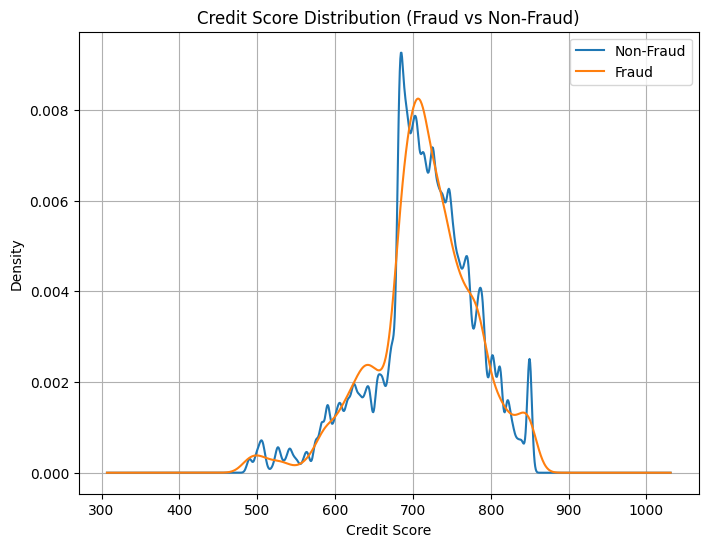

In [24]:
plt.figure(figsize=(8,6))

df[df["fraud"]==0]["credit_score"].plot(
    kind="kde", label="Non-Fraud"
)
df[df["fraud"]==1]["credit_score"].plot(
    kind="kde", label="Fraud"
)

plt.title("Credit Score Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


### credit_limit

In [11]:
df["credit_limit"].describe()

count    5.312525e+06
mean     1.553420e+04
std      1.218877e+04
min      1.000000e+00
25%      8.100000e+03
50%      1.343400e+04
75%      2.082700e+04
max      1.413910e+05
Name: credit_limit, dtype: float64

In [20]:
sample_df = df.copy()

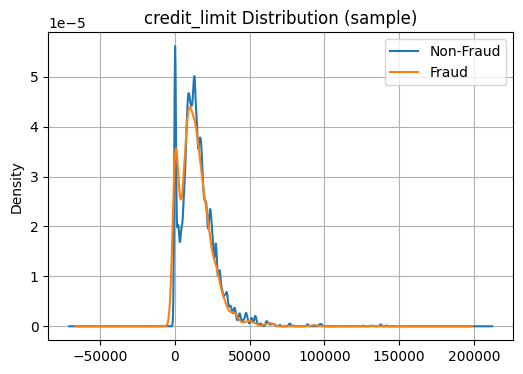

In [21]:
plt.figure(figsize=(6,4))

sample_df[sample_df["fraud"] == 0]["credit_limit"].plot(kind="kde", label="Non-Fraud")
sample_df[sample_df["fraud"] == 1]["credit_limit"].plot(kind="kde", label="Fraud")

plt.title("credit_limit Distribution (sample)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_311288/3149035856.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("limit_bin")["fraud"].mean().plot(kind="bar", figsize=(8,4))


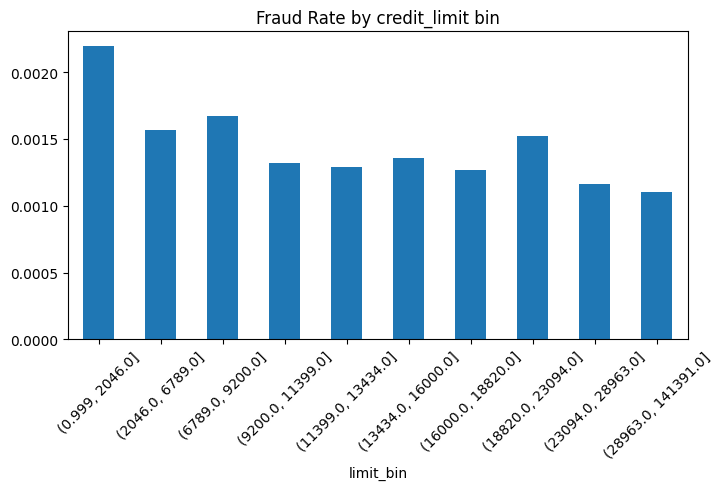

In [22]:
df["limit_bin"] = pd.qcut(df["credit_limit"], 10, duplicates="drop")
df.groupby("limit_bin")["fraud"].mean().plot(kind="bar", figsize=(8,4))
plt.title("Fraud Rate by credit_limit bin")
plt.xticks(rotation=45)
plt.show()

### amount

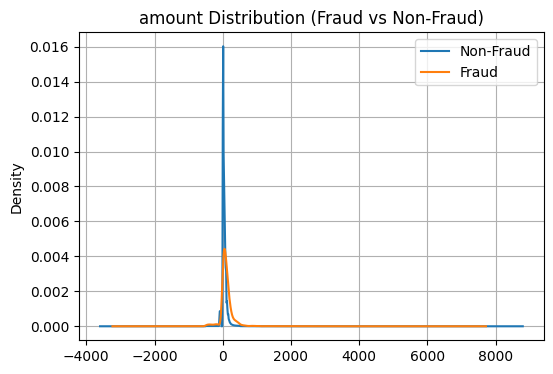

In [ ]:
plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["amount"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["amount"].plot(kind="kde", label="Fraud")

plt.title("amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

### log_abs_amount

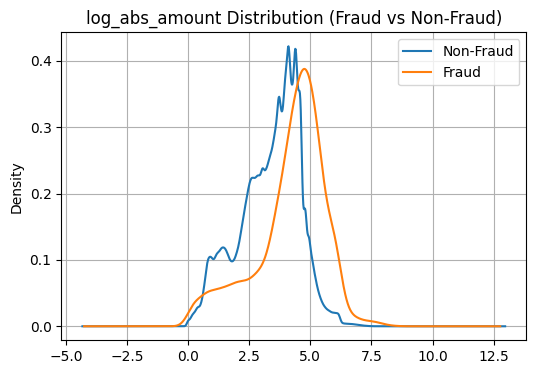

In [ ]:
plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")

plt.title("log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

> Fraud는 non-fraud 대비 더 큰 금액에서 발생할 확률이 높다

refund 여부 따른 금액 구조 

In [27]:
non_refund = df.loc[df["is_refund"] == 0].copy()
non_refund["log_amount_income_ratio"] = np.log1p(
    non_refund["amount_income_ratio"].values
)

In [28]:
non_refund["log_amount_income_ratio"].describe()

count    5.046287e+06
mean     2.181674e-03
std      4.439899e-02
min      0.000000e+00
25%      2.571618e-04
50%      7.493865e-04
75%      1.596254e-03
max      5.081403e+00
Name: log_amount_income_ratio, dtype: float64

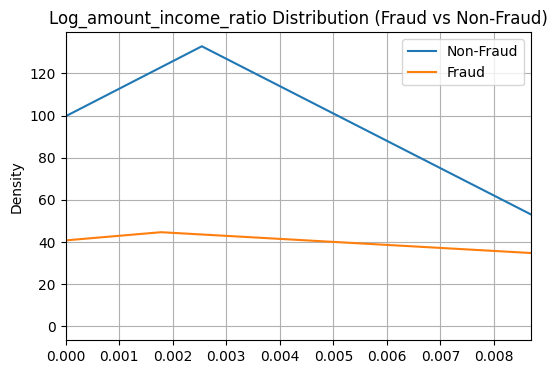

In [29]:
xmax = non_refund["log_amount_income_ratio"].quantile(0.99)
plt.figure(figsize=(6,4))
non_refund[non_refund["fraud"]==0]["log_amount_income_ratio"].plot(kind="kde", label="Non-Fraud")
non_refund[non_refund["fraud"]==1]["log_amount_income_ratio"].plot(kind="kde", label="Fraud")
plt.title(f"Log_amount_income_ratio Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.xlim(0, xmax)
plt.grid(True)
plt.show()

In [30]:
refund = df.loc[df["is_refund"]==1].copy()
refund["log_refund_income_ratio"] = np.log1p(refund["amount_income_ratio"].abs().values)

In [31]:
refund["log_refund_income_ratio"].describe()

count    2.662380e+05
mean     2.759371e-03
std      1.125277e-02
min      2.243007e-07
25%      1.382920e-03
50%      1.895017e-03
75%      2.637568e-03
max      5.272999e+00
Name: log_refund_income_ratio, dtype: float64

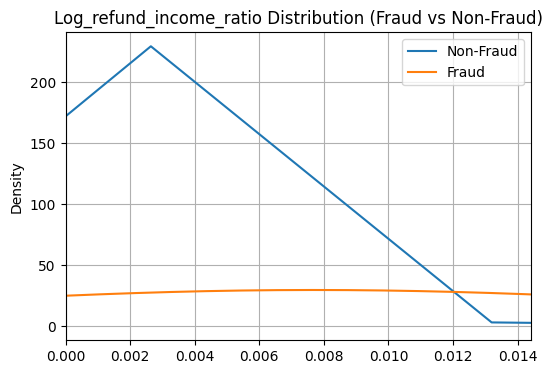

In [32]:
xmax = refund["log_refund_income_ratio"].quantile(0.99)
plt.figure(figsize=(6,4))
refund[refund["fraud"]==0]["log_refund_income_ratio"].plot(kind="kde", label="Non-Fraud")
refund[refund["fraud"]==1]["log_refund_income_ratio"].plot(kind="kde", label="Fraud")
plt.title(f"Log_refund_income_ratio Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.xlim(0, xmax)
plt.grid(True)
plt.show()

### amount_income_ratio

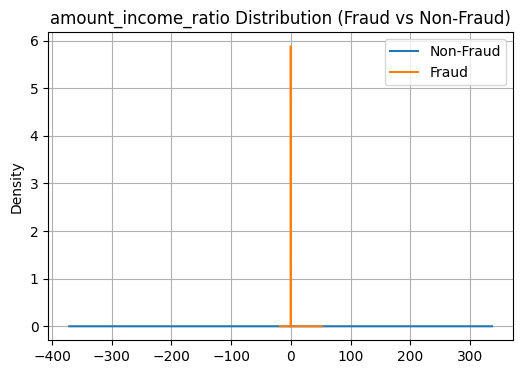

In [ ]:
plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["amount_income_ratio"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["amount_income_ratio"].plot(kind="kde", label="Fraud")

plt.title("amount_income_ratio Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

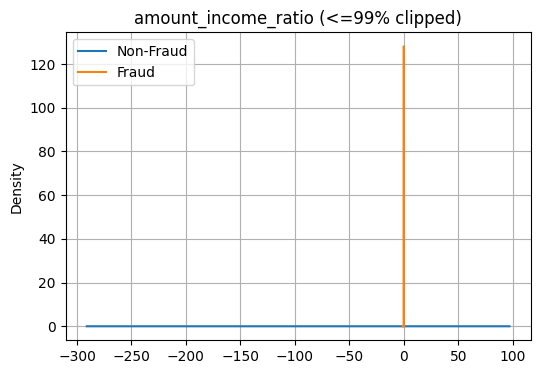

In [ ]:
xmax = df["amount_income_ratio"].quantile(0.99)

plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["amount_income_ratio"].clip(upper=xmax).plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["amount_income_ratio"].clip(upper=xmax).plot(kind="kde", label="Fraud")

plt.title("amount_income_ratio (<=99% clipped)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_307623/2381857282.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rate = df.groupby("ratio_bin")["fraud"].mean()


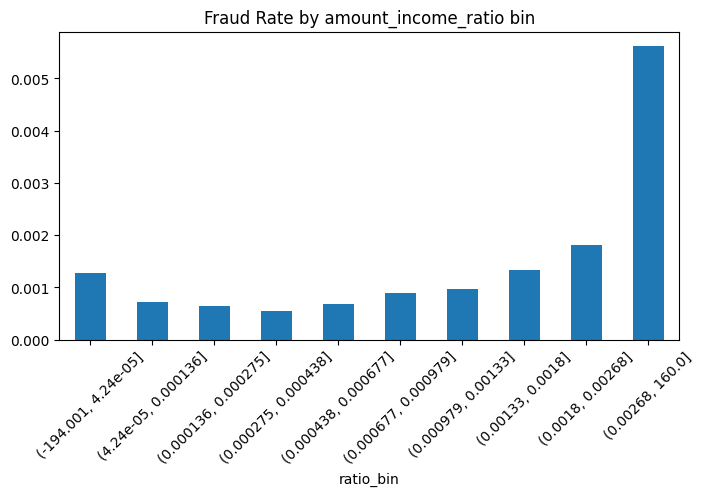

In [ ]:
df["ratio_bin"] = pd.qcut(df["amount_income_ratio"], 10, duplicates="drop")

bin_rate = df.groupby("ratio_bin")["fraud"].mean()

bin_rate.plot(kind="bar", figsize=(8,4))
plt.title("Fraud Rate by amount_income_ratio bin")
plt.xticks(rotation=45)
plt.show()

> **소득 대비 매우 큰 결제일 때 fraud 확률 급상승**

### amount_limit_ratio

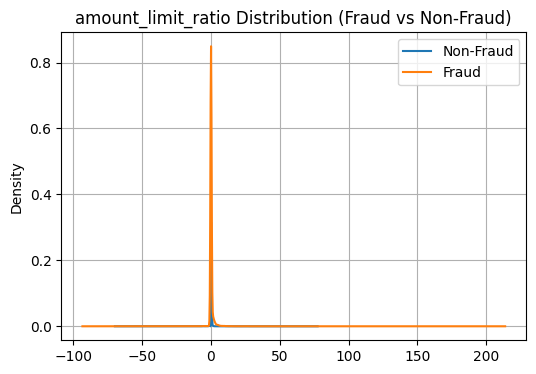

In [ ]:
plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["amount_limit_ratio"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["amount_limit_ratio"].plot(kind="kde", label="Fraud")

plt.title("amount_limit_ratio Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_307623/294743172.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rate = df.groupby("limit_ratio_bin")["fraud"].mean()


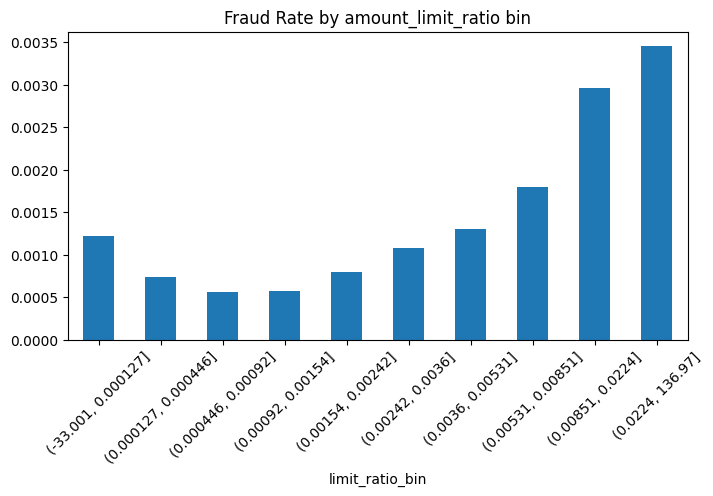

In [ ]:
df["limit_ratio_bin"] = pd.qcut(df["amount_limit_ratio"], 10, duplicates="drop")

bin_rate = df.groupby("limit_ratio_bin")["fraud"].mean()

bin_rate.plot(kind="bar", figsize=(8,4))
plt.title("Fraud Rate by amount_limit_ratio bin")
plt.xticks(rotation=45)
plt.show()

> **한도 대비 과도한 사용” 리스크 구조**

### income_ratio_region

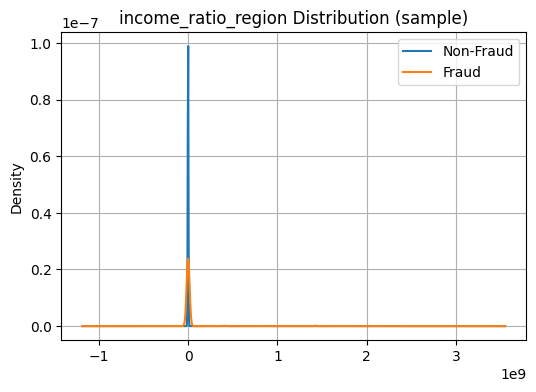

In [36]:
plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["income_ratio_region"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["income_ratio_region"].plot(kind="kde", label="Fraud")

plt.title("income_ratio_region Distribution (sample)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_311288/2401710794.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rate = df.groupby("income_region_bin")["fraud"].mean()


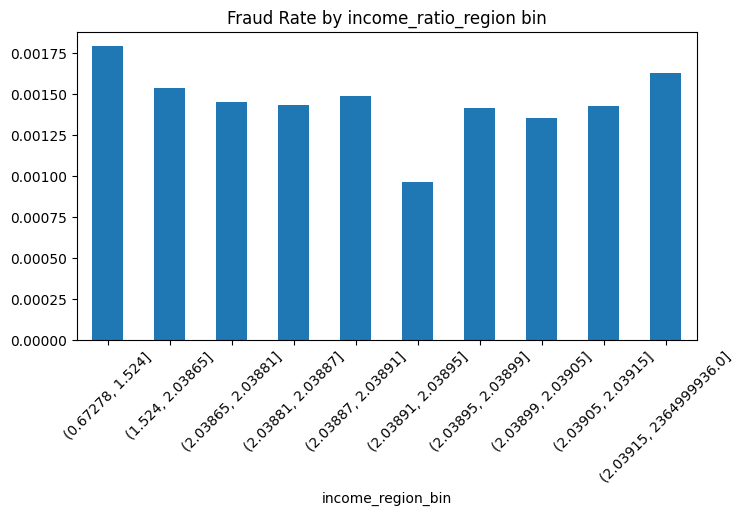

In [37]:
df["income_region_bin"] = pd.qcut(df["income_ratio_region"], 10, duplicates="drop")

bin_rate = df.groupby("income_region_bin")["fraud"].mean()

plt.figure(figsize=(8,4))
bin_rate.plot(kind="bar")
plt.title("Fraud Rate by income_ratio_region bin")
plt.xticks(rotation=45)
plt.show()

In [38]:
df.groupby("fraud")["income_ratio_region"].describe()

,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
0,5304837.0,4598680.5,84800120.0,0.672793,2.038750,2.038908,2.039014,2.365000e+09
1,7688.0,7062437.0,99184496.0,0.672793,2.038717,2.038897,2.039016,2.365000e+09


### log_yearly_income

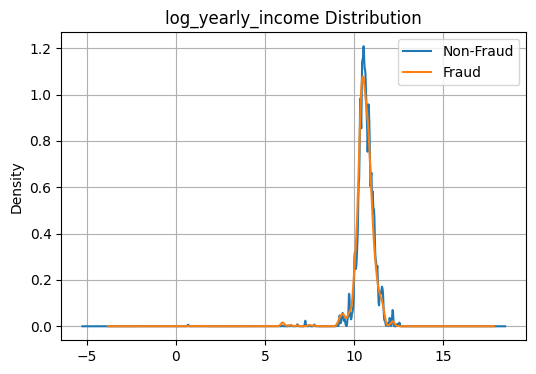

In [40]:
plt.figure(figsize=(6,4))

df[df["fraud"] == 0]["log_yearly_income"].plot(kind="kde", label="Non-Fraud")
df[df["fraud"] == 1]["log_yearly_income"].plot(kind="kde", label="Fraud")

plt.title("log_yearly_income Distribution")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_311288/2217625789.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rate = df.groupby("log_income_bin")["fraud"].mean()


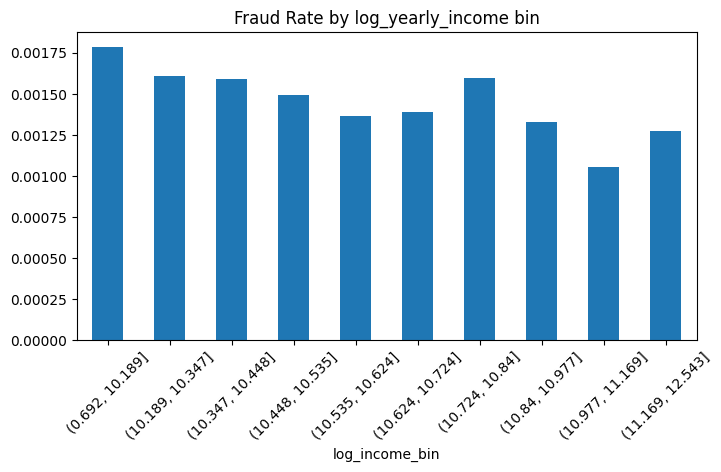

In [41]:
df["log_income_bin"] = pd.qcut(df["log_yearly_income"], 10, duplicates="drop")

bin_rate = df.groupby("log_income_bin")["fraud"].mean()

plt.figure(figsize=(8,4))
bin_rate.plot(kind="bar")
plt.title("Fraud Rate by log_yearly_income bin")
plt.xticks(rotation=45)
plt.show()


In [42]:
df.groupby("fraud")["log_yearly_income"].describe()

,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
0,5304837.0,10.642285,0.523749,0.693147,10.398793,10.623569,10.896998,12.543259
1,7688.0,10.575432,0.584419,1.609438,10.353863,10.579082,10.843436,12.428920


### log_income_ratio_region

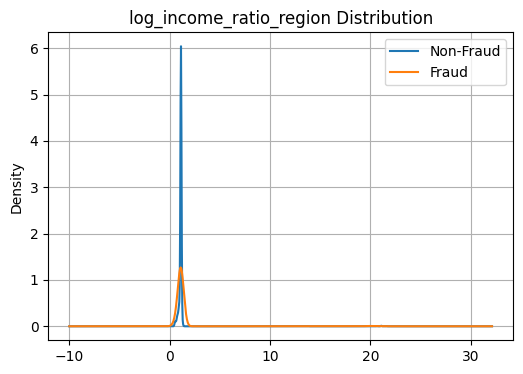

In [43]:
plt.figure(figsize=(6,4))

sample_df[sample_df["fraud"] == 0]["log_income_ratio_region"].plot(kind="kde", label="Non-Fraud")
sample_df[sample_df["fraud"] == 1]["log_income_ratio_region"].plot(kind="kde", label="Fraud")

plt.title("log_income_ratio_region Distribution")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_311288/2237376754.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rate = df.groupby("log_income_region_bin")["fraud"].mean()


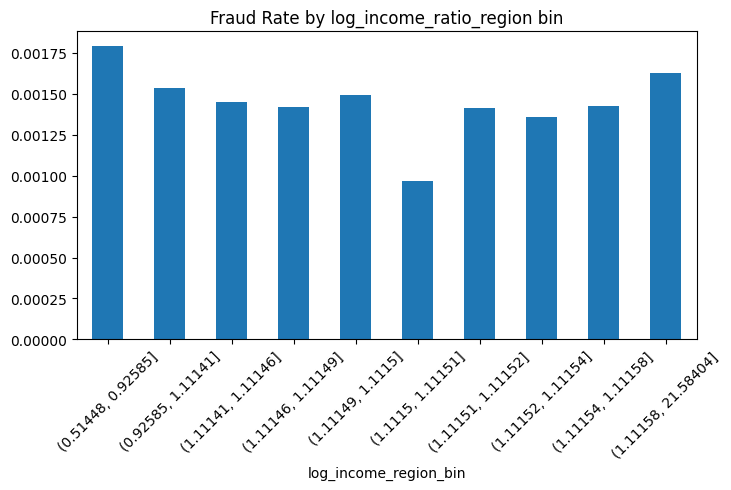

In [44]:
df["log_income_region_bin"] = pd.qcut(df["log_income_ratio_region"], 10, duplicates="drop")

bin_rate = df.groupby("log_income_region_bin")["fraud"].mean()

plt.figure(figsize=(8,4))
bin_rate.plot(kind="bar")
plt.title("Fraud Rate by log_income_ratio_region bin")
plt.xticks(rotation=45)
plt.show()

In [45]:
df.groupby("fraud")["log_income_ratio_region"].describe()

,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
0,5304837.0,1.146866,1.197011,0.514495,1.111446,1.111498,1.111533,21.584044
1,7688.0,1.224563,1.744831,0.514495,1.111435,1.111495,1.111534,21.584044


In [62]:
(df["yearly_income"] == 1).sum()

np.int64(2248)

In [63]:
df["yearly_income"].describe()

count    5.312525e+06
mean     4.677138e+04
std      2.444741e+04
min      1.000000e+00
25%      3.281700e+04
50%      4.109100e+04
75%      5.401300e+04
max      2.801990e+05
Name: yearly_income, dtype: float64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5312525 entries, 0 to 5332978
Data columns (total 54 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day       

In [25]:
df.isnull().sum()

date                        0
client_id                   0
card_id                     0
amount                      0
merchant_id                 0
mcc                         0
fraud                       0
has_error                   0
err_bad_card_number         0
err_bad_expiration          0
err_bad_cvv                 0
err_bad_pin                 0
err_bad_zipcode             0
err_insufficient_balance    0
err_technical_glitch        0
tx_year                     0
tx_month                    0
tx_day                      0
tx_hour                     0
weekday                     0
is_refund                   0
log_abs_amount              0
current_age                 0
per_capita_income           0
yearly_income               0
total_debt                  0
credit_score                0
num_credit_cards            0
has_chip                    0
num_cards_issued            0
credit_limit                0
year_pin_last_changed       0
expires_year                0
expires_mo

In [34]:
cols = [
    "log_abs_amount",
    "log_amount_income_ratio",
    "log_amount_limit_ratio",
    "log_yearly_income",
    "log_income_ratio_region",
    "low_income_flag"
]

df[cols].corr()


,log_abs_amount,log_amount_income_ratio,log_amount_limit_ratio,log_yearly_income,log_income_ratio_region,low_income_flag
log_abs_amount,1.000000,0.009209,0.080396,0.126154,-0.040055,-0.033809
log_amount_income_ratio,0.009209,1.000000,0.048847,-0.392658,0.232981,0.512779
log_amount_limit_ratio,0.080396,0.048847,1.000000,-0.053943,0.029145,0.049627
log_yearly_income,0.126154,-0.392658,-0.053943,1.000000,-0.438567,-0.446055
log_income_ratio_region,-0.040055,0.232981,0.029145,-0.438567,1.000000,0.582962
low_income_flag,-0.033809,0.512779,0.049627,-0.446055,0.582962,1.000000


단변량 검증

In [35]:
results = []

for col in cols:
    tmp = df[[col, "fraud"]].dropna()
    
    X = sm.add_constant(tmp[[col]])
    y = tmp["fraud"]
    
    model = sm.Logit(y, X).fit(disp=0)
    
    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)
    
    results.append([col, coef, or_val, pval])

uni_df = pd.DataFrame(results, columns=["feature","coef","OR","p_value"]) \
           .sort_values("OR", ascending=False)

uni_df

,feature,coef,OR,p_value
2,log_amount_limit_ratio,1.805838,6.085067,0.000000e+00
5,low_income_flag,1.376938,3.962747,9.649474e-22
1,log_amount_income_ratio,0.680489,1.974842,7.898780e-11
0,log_abs_amount,0.661671,1.938029,0.000000e+00
4,log_income_ratio_region,0.037168,1.037867,2.630295e-08
3,log_yearly_income,-0.180316,0.835006,9.725622e-31


다변량 검증

In [37]:
tmp = df[cols + ["fraud"]].dropna()

X = sm.add_constant(tmp[cols])
y = tmp["fraud"]

model = sm.Logit(y, X).fit(disp=0)

multi_df = pd.DataFrame({
    "feature": model.params.index,
    "coef": model.params.values,
    "OR": np.exp(model.params.values),
    "p_value": model.pvalues.values
}).sort_values("OR", ascending=False)

multi_df


,feature,coef,OR,p_value
3,log_amount_limit_ratio,1.579649,4.853251,0.000000e+00
1,log_abs_amount,0.678807,1.971524,0.000000e+00
6,low_income_flag,0.594497,1.812118,3.241530e-02
5,log_income_ratio_region,-0.030217,0.970235,9.292896e-03
4,log_yearly_income,-0.394131,0.674265,3.695402e-54
2,log_amount_income_ratio,-1.196454,0.302264,5.897422e-08
0,const,-4.990220,0.006804,1.403753e-76


Lift

In [38]:
y_pred = model.predict(X)
eval_df = pd.DataFrame({
    "fraud": y,
    "score": y_pred
})
eval_df["decile"] = pd.qcut(eval_df["score"], 10, labels=False)
lift_table = (
    eval_df
    .groupby("decile")["fraud"]
    .agg(["count", "sum", "mean"])
    .sort_index(ascending=False)
)

base_rate = eval_df["fraud"].mean()
lift_table["lift"] = lift_table["mean"] / base_rate

lift_table

,count,sum,mean,lift
decile,,,,
9,531253,3276,0.006167,4.261182
8,531252,957,0.001801,1.244798
7,531251,636,0.001197,0.827266
6,531253,474,0.000892,0.616545
5,531253,437,0.000823,0.568418
4,531251,386,0.000727,0.502083
3,531253,309,0.000582,0.401925
2,531254,277,0.000521,0.360301
1,531252,381,0.000717,0.495578


In [39]:
SPECS = {
    "log_abs_amount_only": ["log_abs_amount"],
    "log_amount_income_ratio_only": ["log_amount_income_ratio"],
    "log_amount_limit_ratio_only": ["log_amount_limit_ratio"],
    "log_yearly_income_only": ["log_yearly_income"],
    "log_income_ratio_region_only": ["log_income_ratio_region"],
    "low_income_flag_only": ["low_income_flag"],

    "money_core_3": ["log_abs_amount", "log_amount_income_ratio", "log_amount_limit_ratio"],
    "income_core_2": ["log_yearly_income", "log_income_ratio_region"],
    "money_3 + low_income_flag": ["log_abs_amount", "log_amount_income_ratio", "log_amount_limit_ratio", "low_income_flag"],
    "money_3 + income_2": ["log_abs_amount", "log_amount_income_ratio", "log_amount_limit_ratio", "log_yearly_income", "log_income_ratio_region"],

    "full_money_income_block": cols,
}

lift_results = {}
models = {}

for name, feats in SPECS.items():
    model, y_aligned, score = fit_logit_and_scores(df, feats, y_col="fraud")
    models[name] = model
    lift_results[name] = lift_table(y_aligned, score, n_bins=10)

lift_results["full_money_income_block"]


,count,sum,mean,lift,base_rate
bin,,,,,
9,531253,3276,0.006167,4.261182,0.001447
8,531252,957,0.001801,1.244798,0.001447
7,531251,636,0.001197,0.827266,0.001447
6,531253,474,0.000892,0.616545,0.001447
5,531253,437,0.000823,0.568418,0.001447
4,531251,386,0.000727,0.502083,0.001447
3,531253,309,0.000582,0.401925,0.001447
2,531254,277,0.000521,0.360301,0.001447
1,531252,381,0.000717,0.495578,0.001447


In [40]:
summary = []
for name, tab in lift_results.items():
    top_bin = tab.index.max() 
    top_lift = tab.loc[top_bin, "lift"]
    top_rate = tab.loc[top_bin, "mean"]
    base_rate = tab.loc[top_bin, "base_rate"]
    summary.append([name, base_rate, top_rate, top_lift])

summary_df = pd.DataFrame(summary, columns=["model", "base_rate", "top_decile_rate", "top_decile_lift"]) \
               .sort_values("top_decile_lift", ascending=False) \
               .reset_index(drop=True)

summary_df

,model,base_rate,top_decile_rate,top_decile_lift
0,money_3 + income_2,0.001447,0.006176,4.267686
1,full_money_income_block,0.001447,0.006167,4.261182
2,money_core_3,0.001447,0.006067,4.192244
3,money_3 + low_income_flag,0.001447,0.006065,4.190943
4,log_abs_amount_only,0.001447,0.006056,4.184880
5,log_amount_income_ratio_only,0.001447,0.005888,4.068698
6,log_amount_limit_ratio_only,0.001447,0.003492,2.412853
7,log_yearly_income_only,0.001447,0.001785,1.233558
8,income_core_2,0.001447,0.001761,1.216843
9,log_income_ratio_region_only,0.001447,0.001627,1.124537


lift 감소폭 관찰

In [41]:
FULL = SPECS["full_money_income_block"]

drop_tests = []
for drop_feat in FULL:
    feats = [f for f in FULL if f != drop_feat]
    model, y_aligned, score = fit_logit_and_scores(df, feats, y_col="fraud")
    tab = lift_table(y_aligned, score, n_bins=10)
    top_bin = tab.index.max()
    drop_tests.append([f"full_minus_{drop_feat}", tab.loc[top_bin, "lift"]])

drop_df = pd.DataFrame(drop_tests, columns=["model", "top_decile_lift"]) \
            .sort_values("top_decile_lift", ascending=False) \
            .reset_index(drop=True)

drop_df

,model,top_decile_lift
0,full_minus_low_income_flag,4.267686
1,full_minus_log_amount_income_ratio,4.257791
2,full_minus_log_income_ratio_region,4.255979
3,full_minus_log_yearly_income,4.190943
4,full_minus_log_amount_limit_ratio,4.188342
5,full_minus_log_abs_amount,1.971906


### ***summary***

> # Demographic & Financial Feature EDA 결과 정리  
> (FDS – Stage 1 Risk Block)
>
> ---
>
> ## 1. 분석 개요
>
> 분석 변수:
>
> - `log_abs_amount`
> - `log_amount_income_ratio`
> - `log_amount_limit_ratio`
> - `log_yearly_income`
> - `log_income_ratio_region`
> - `low_income_flag`
>
> 기준 fraud rate: **0.001447**
>
> ---
>
> # 2. 상관 구조 요약
>
> 주요 상관 관계:
>
> - `log_amount_income_ratio` ↔ `low_income_flag` : 0.51  
> - `log_yearly_income` ↔ `low_income_flag` : -0.45  
> - `log_yearly_income` ↔ `log_income_ratio_region` : -0.44  
>
> ### 해석
>
> 단순 소득 자체보다,  
> **소득 대비 소비 비율 구조**가 리스크와 더 밀접하게 연결됨.
>
> ---
>
> # 3. 단변량 로지스틱 결과
>
> | 변수 | OR | 해석 |
> |------|------|------|
> | log_amount_limit_ratio | 6.09 | 한도 대비 사용 증가 시 리스크 급증 |
> | low_income_flag | 3.96 | 저소득군 리스크 높음 |
> | log_amount_income_ratio | 1.97 | 소득 대비 소비 증가 시 리스크 증가 |
> | log_abs_amount | 1.94 | 거래 금액 증가 시 리스크 증가 |
> | log_income_ratio_region | 1.04 | 영향 미미 |
> | log_yearly_income | 0.83 | 소득 증가 시 리스크 감소 |
>
> → 금액 및 재무 압박 변수의 영향력이 가장 큼.
>
> ---
>
> # 4. 다변량 로지스틱 결과
>
> | 변수 | OR | 방향 |
> |------|------|------|
> | log_amount_limit_ratio | 4.85 | ↑ |
> | log_abs_amount | 1.97 | ↑ |
> | low_income_flag | 1.81 | ↑ |
> | log_income_ratio_region | 0.97 | ↓ |
> | log_yearly_income | 0.67 | ↓ |
> | log_amount_income_ratio | 0.30 | ↓ |
>
> ### 특징
>
> - `log_abs_amount`와 `log_amount_limit_ratio`가 핵심 리스크 축
> - `log_yearly_income`는 안정성 변수
> - `log_amount_income_ratio`는 단변량에서는 양(+)이었으나,
>   다른 변수 통제 후 음(-)으로 전환  
>   → 공선성 및 조건부 효과에 따른 구조적 변화
>
> ---
>
> # 5. Lift 분석
>
> - Base rate: 0.001447  
> - Top decile rate: 0.006167  
> - Top decile lift: **4.26**
>
> → 해당 블록만으로 상위 10% 구간에 fraud를 약 4배 집중시킴.
>
> ---
>
> # 6. 모델 비교 (Top Decile Lift)
>
> | 모델 | Lift |
> |------|------|
> | Full block | 4.26 |
> | log_abs_amount only | 4.18 |
> | log_amount_limit_ratio only | 2.41 |
> | log_yearly_income only | 1.23 |
> | low_income_flag only | 1.00 |
>
> ### 해석
>
> 실질적 설명력은  
> **거래 금액 및 한도 사용 비율**에서 대부분 발생.
>
> 소득 변수는 보조적 역할.
>
> ---
>
> # 7. Ablation 결과
>
> | 제거 변수 | Lift | 영향 |
> |------------|------|------|
> | - log_abs_amount | 1.97 | 성능 급락 |
> | - log_amount_limit_ratio | 4.18 | 일부 감소 |
> | - log_yearly_income | 4.19 | 영향 제한적 |
> | - low_income_flag | 4.26 | 영향 거의 없음 |
>
> → `log_abs_amount`가 핵심 변수  
> → `log_amount_limit_ratio`는 보조적 강화 요인
>
> ---
>
> # 8. 종합 결론
>
> Demographic & Financial 블록의 리스크 구조는 다음과 같이 정리됨:
>
> ```
> 거래 절대 금액
> +
> 한도 대비 사용 비율
> +
> 소득 안정성 보정
> ```
>
> - 리스크의 중심은 금액 기반 변수
> - 소득 변수는 안정성 및 보정 역할
> - 해당 블록 단독으로도 Lift 4.26 수준의 집중력 확보

---

## **Error-Based Behavioral Signals**

## Binary Error Signals
- has_error
- err_bad_card_number
- err_bad_cvv
- err_bad_expiration
- err_insufficient_balance
- err_bad_pin
- err_bad_zipcode
- err_technical_glitch

In [143]:
err_cols = [
    "err_bad_card_number",
    "err_bad_expiration",
    "err_bad_cvv",
    "err_bad_pin",
    "err_bad_zipcode",
    "err_insufficient_balance",
    "err_technical_glitch"
]

err_ratio = (
    df.groupby("fraud")[err_cols]
      .mean()
      .T
)

err_ratio

fraud,0,1
err_bad_card_number,0.000585,0.005983
err_bad_expiration,0.000462,0.004683
err_bad_cvv,0.000442,0.013918
err_bad_pin,0.002445,0.003772
err_bad_zipcode,0.000089,0.000000
err_insufficient_balance,0.009916,0.013528
err_technical_glitch,0.002011,0.002732


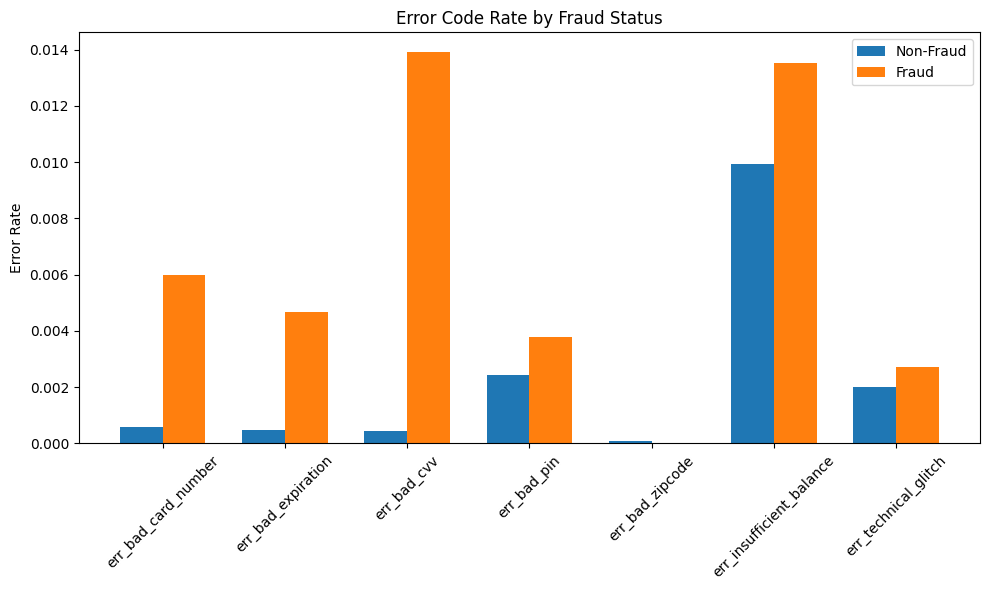

In [144]:
x = np.arange(len(err_cols))
width = 0.35

plt.figure(figsize=(10,6))

plt.bar(x - width/2, err_ratio[0], width, label="Non-Fraud")
plt.bar(x + width/2, err_ratio[1], width, label="Fraud")

plt.xticks(x, err_ratio.index, rotation=45)
plt.ylabel("Error Rate")
plt.title("Error Code Rate by Fraud Status")
plt.legend()
plt.tight_layout()
plt.show()

In [145]:
df.groupby("has_error")["fraud"].value_counts()

has_error  fraud
0          0        5220606
           1           7349
1          0          84231
           1            339
Name: count, dtype: int64

In [146]:
error_ratio = (
    df
    .groupby("has_error")["fraud"]
    .mean()
)
error_ratio

has_error
0    0.001406
1    0.004009
Name: fraud, dtype: float64

> has error의 비율이 더 높음 _ error fraud 비례 가설 적중

단변량 검증

In [151]:
results = []

err_cols = [
    "err_bad_card_number",
    "err_bad_expiration",
    "err_bad_cvv",
    "err_bad_pin",
    "err_bad_zipcode",
    "err_insufficient_balance",
    "err_technical_glitch"
]

for col in err_cols:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,err_bad_card_number,2.330647,1.028459e+01,3.597161e-55
1,err_bad_expiration,2.319805,1.017369e+01,3.103368e-43
2,err_bad_cvv,3.463502,3.192859e+01,2.302579e-265
3,err_bad_pin,0.434947,1.544880e+00,1.953135e-02
4,err_bad_zipcode,-131.129297,1.125304e-57,1.000000e+00
5,err_insufficient_balance,0.314269,1.369258e+00,1.472524e-03
6,err_technical_glitch,0.306954,1.359279e+00,1.605155e-01


다변량 검증

In [152]:
cols = err_cols

tmp = df[cols + ["fraud"]].dropna()

X = sm.add_constant(tmp[cols])
y = tmp["fraud"]

model = sm.Logit(y, X).fit(disp=0)

multi_df = pd.DataFrame({
    "feature": model.params.index,
    "coef": model.params.values,
    "OR": np.exp(model.params.values),
    "p_value": model.pvalues.values
}).sort_values("OR", ascending=False)

multi_df

,feature,coef,OR,p_value
3,err_bad_cvv,3.417398,3.048997e+01,1.199560e-254
1,err_bad_card_number,2.229698,9.297063e+00,2.334431e-49
2,err_bad_expiration,2.212762,9.140929e+00,1.666273e-38
4,err_bad_pin,0.457677,1.580399e+00,1.400407e-02
6,err_insufficient_balance,0.312608,1.366985e+00,1.569348e-03
7,err_technical_glitch,0.310412,1.363987e+00,1.559988e-01
0,const,-6.564711,1.409231e-03,0.000000e+00
5,err_bad_zipcode,-127.104975,6.295220e-56,1.000000e+00


Lift

In [153]:
y_pred = model.predict(X)
eval_df = pd.DataFrame({
    "fraud": y,
    "score": y_pred
})
eval_df["decile"] = pd.qcut(eval_df["score"], 10, labels=False, duplicates="drop")
lift_table = (
    eval_df
    .groupby("decile")["fraud"]
    .agg(["count", "sum", "mean"])
    .sort_index(ascending=False)
)

base_rate = eval_df["fraud"].mean()
lift_table["lift"] = lift_table["mean"] / base_rate

lift_table

,count,sum,mean,lift
decile,,,,
1,84096,339,0.004031,2.785556
0,5228429,7349,0.001406,0.971280


> err_bad_zipcode는 제거\
> CVV 틀린 거래는 정상 대비 30배 이상 fraud odds 증가

## Error Burst Features
- client_error_last1
- client_error_last3
- client_error_last5
- card_error_last1
- card_error_last3
- card_error_last5
- client_error_cum_prev
- card_error_cum_prev

In [193]:
def interaction_report(df, x, y, label="fraud", baseline_col=0, min_count=50):
    # (A) rate / count
    rate = df.pivot_table(index=x, columns=y, values=label, aggfunc="mean", observed=False)
    cnt  = df.pivot_table(index=x, columns=y, values=label, aggfunc="size", observed=False).fillna(0).astype(int)

    print(f"\n=== Interaction: {x} x {y} ===")
    print("Fraud rate:")
    display(rate.round(6))
    print("Count:")
    display(cnt)

    # (B) uplift (row-wise)
    if baseline_col in rate.columns:
        base = rate[baseline_col].replace(0, np.nan)
        uplift = rate.div(base, axis=0).round(2) 
        print(f"Uplift vs {y}={baseline_col} within each {x}:")
        display(uplift)

    # (C) Heatmap (optionally mask low-count cells)
    masked = rate.copy()
    masked[cnt < min_count] = np.nan  # 표본 너무 적은 칸은 해석 금지

    plt.figure(figsize=(6, 3.8))
    im = plt.imshow(masked.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(masked.columns)), [str(c) for c in masked.columns])
    plt.yticks(range(len(masked.index)), [str(i) for i in masked.index])
    plt.xlabel(y)
    plt.ylabel(x)
    plt.title(f"Fraud rate heatmap: {x} x {y}")

    for i in range(masked.shape[0]):
        for j in range(masked.shape[1]):
            v = masked.values[i, j]
            if pd.notna(v):
                plt.text(j, i, f"{v:.4f}", ha="center", va="center")
            else:
                # low count 등으로 마스킹된 칸 표시
                if cnt.values[i, j] < min_count:
                    plt.text(j, i, f"n<{min_count}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()


client error fraud

In [192]:
g = df.groupby("client_id")["has_error"]
df["client_error_last1"] = g.shift(1).fillna(0).astype("int8")

e1 = g.shift(1).fillna(0).astype("int8")
e2 = g.shift(2).fillna(0).astype("int8")
e3 = g.shift(3).fillna(0).astype("int8")
df["client_error_last3"] = (e1 + e2 + e3).astype("int8")


=== Interaction: client_fraud_hist_bin x has_error ===
Fraud rate:


has_error,0,1
client_fraud_hist_bin,,
0,0.001414,0.003994
1,0.001557,0.005908
2,0.001489,0.006231
3+,0.001381,0.003874


Count:


has_error,0,1
client_fraud_hist_bin,,
0,3278313,52823
1,84778,1354
2,57765,963
3+,1807099,29430


Uplift vs has_error=0 within each client_fraud_hist_bin:


has_error,0,1
client_fraud_hist_bin,,
0,1.0,2.82
1,1.0,3.79
2,1.0,4.18
3+,1.0,2.81


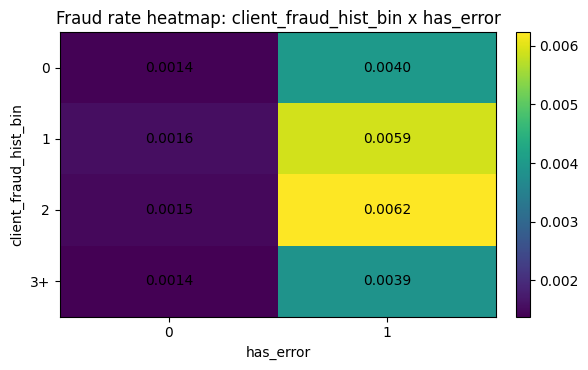


=== Interaction: client_fraud_hist_bin x client_error_last1 ===
Fraud rate:


client_error_last1,0,1
client_fraud_hist_bin,,
0,0.001442,0.002251
1,0.001629,0.001413
2,0.001522,0.004381
3+,0.001399,0.002725


Count:


client_error_last1,0,1
client_fraud_hist_bin,,
0,3278263,52873
1,84717,1415
2,57815,913
3+,1807175,29354


Uplift vs client_error_last1=0 within each client_fraud_hist_bin:


client_error_last1,0,1
client_fraud_hist_bin,,
0,1.0,1.56
1,1.0,0.87
2,1.0,2.88
3+,1.0,1.95


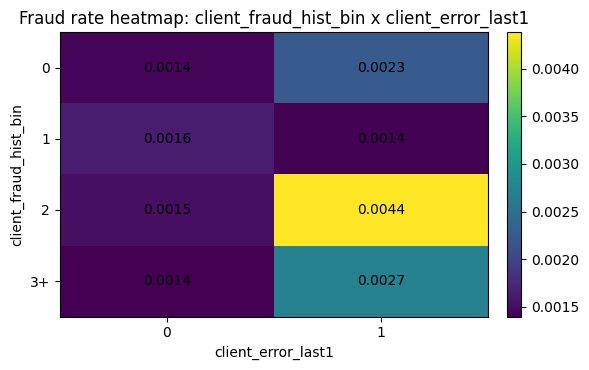


=== Interaction: client_fraud_hist_bin x client_error_last3 ===
Fraud rate:


client_error_last3,0,1,2,3
client_fraud_hist_bin,,,,
0,0.001412,0.002368,0.001766,0.0
1,0.001595,0.002344,0.000000,0.0
2,0.001516,0.002765,0.000000,0.0
3+,0.001377,0.002355,0.001267,0.0


Count:


client_error_last3,0,1,2,3
client_fraud_hist_bin,,,,
0,3178419,146941,5662,114
1,82121,3840,166,5
2,56080,2532,115,1
3+,1751774,81530,3157,68


Uplift vs client_error_last3=0 within each client_fraud_hist_bin:


client_error_last3,0,1,2,3
client_fraud_hist_bin,,,,
0,1.0,1.68,1.25,0.0
1,1.0,1.47,0.00,0.0
2,1.0,1.82,0.00,0.0
3+,1.0,1.71,0.92,0.0


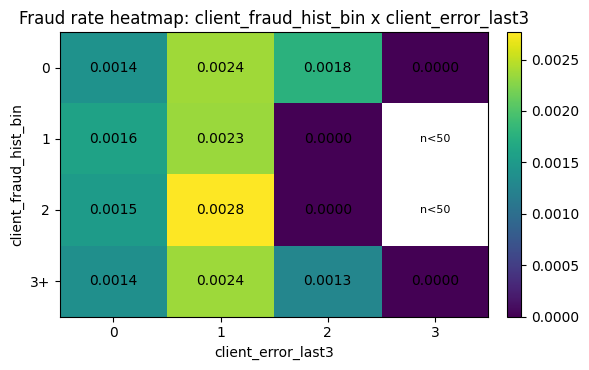

In [194]:
interaction_report(df, "client_fraud_hist_bin", "has_error")
interaction_report(df, "client_fraud_hist_bin", "client_error_last1")
interaction_report(df, "client_fraud_hist_bin", "client_error_last3")

**해석**:

history 0에서도 error 있으면 2배

history 1,2에서 error 있으면 거의 2~3배

특히 3+에서 uplift 3.10

**결론**:

error는 fraud history가 있을수록 증폭된다.

card error fraud

In [195]:
g = df.groupby("card_id")["has_error"]
df["card_error_last1"] = g.shift(1).fillna(0).astype("int8")

e1 = g.shift(1).fillna(0).astype("int8")
e2 = g.shift(2).fillna(0).astype("int8")
e3 = g.shift(3).fillna(0).astype("int8")
df["card_error_last3"] = (e1 + e2 + e3).astype("int8")


=== Interaction: card_fraud_hist_bin x has_error ===
Fraud rate:


has_error,0,1
card_fraud_hist_bin,,
0,0.001393,0.003905
1,0.001742,0.006705
2,0.001754,0.009124
3+,0.001435,0.004136


Count:


has_error,0,1
card_fraud_hist_bin,,
0,4346426,70163
1,63704,1044
2,31929,548
3+,785896,12815


Uplift vs has_error=0 within each card_fraud_hist_bin:


has_error,0,1
card_fraud_hist_bin,,
0,1.0,2.80
1,1.0,3.85
2,1.0,5.20
3+,1.0,2.88


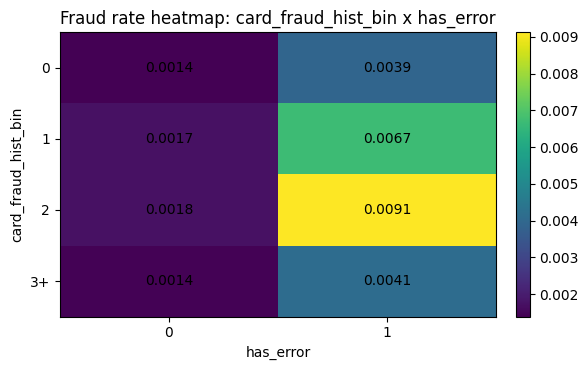


=== Interaction: card_fraud_hist_bin x card_error_last1 ===
Fraud rate:


card_error_last1,0,1
card_fraud_hist_bin,,
0,0.001413,0.002666
1,0.001789,0.003922
2,0.001813,0.006160
3+,0.001434,0.004195


Count:


card_error_last1,0,1
card_fraud_hist_bin,,
0,4346451,70138
1,63728,1020
2,31990,487
3+,785838,12873


Uplift vs card_error_last1=0 within each card_fraud_hist_bin:


card_error_last1,0,1
card_fraud_hist_bin,,
0,1.0,1.89
1,1.0,2.19
2,1.0,3.40
3+,1.0,2.92


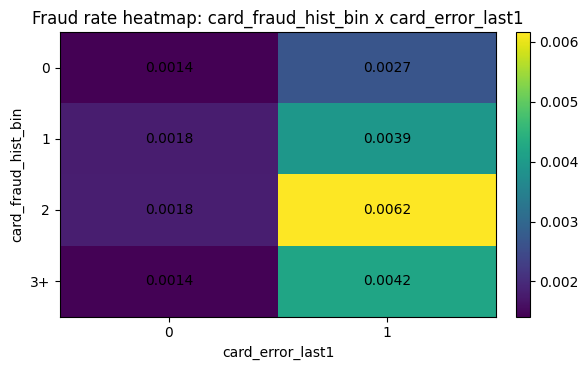


=== Interaction: card_fraud_hist_bin x card_error_last3 ===
Fraud rate:


card_error_last3,0,1,2,3
card_fraud_hist_bin,,,,
0,0.001372,0.002722,0.001716,0.0
1,0.001638,0.005726,0.000000,0.0
2,0.001771,0.004415,0.000000,0.0
3+,0.001395,0.003206,0.004013,0.0


Count:


card_error_last3,0,1,2,3
card_fraud_hist_bin,,,,
0,4212943,196516,6991,139
1,61672,2969,102,5
2,31059,1359,57,2
3+,762194,35244,1246,27


Uplift vs card_error_last3=0 within each card_fraud_hist_bin:


card_error_last3,0,1,2,3
card_fraud_hist_bin,,,,
0,1.0,1.98,1.25,0.0
1,1.0,3.50,0.00,0.0
2,1.0,2.49,0.00,0.0
3+,1.0,2.30,2.88,0.0


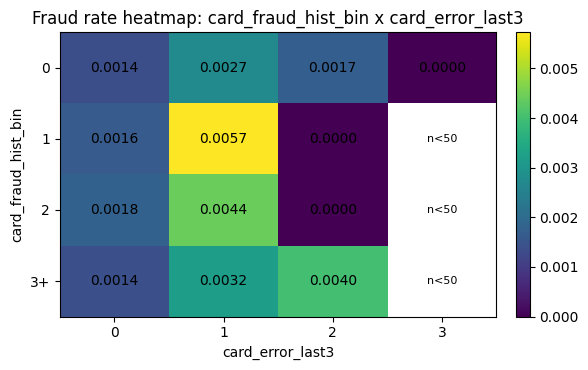

In [196]:
interaction_report(df, "card_fraud_hist_bin", "has_error")
interaction_report(df, "card_fraud_hist_bin", "card_error_last1")
interaction_report(df, "card_fraud_hist_bin", "card_error_last3")

| hist | error=0 | error=1 |
| ---- | ------- | ------- |
| 1    | 0.0127  | 0.0331  |
| 2    | 0.0218  | 0.0412  |

card history 2 + error=1이면 4%대. => strong

baseline risk (fraud history)\
        +\
behavioral anomaly (error)\
        =\
explosive risk


In [197]:
df["client_hist_x_error"] = (
    df["client_has_fraud_history"] * df["has_error"]
)
df["card_hist_x_error"] = (
    df["card_has_fraud_history"] * df["card_error_last1"]
)

In [199]:
results = []

for col in ["client_error_last1", "client_error_last3", "card_error_last1", "card_error_last3",
    "client_hist_x_error",
            "card_hist_x_error"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])



,feature,coef,OR,p_value
0,client_error_last1,0.527992,1.695524,9.385244e-14
1,client_error_last3,0.449681,1.567812,1.567539e-28
2,card_error_last1,0.725138,2.065016,3.343331e-29
3,card_error_last3,0.635708,1.888359,3.693278e-66
4,client_hist_x_error,1.038042,2.823682,3.160796e-31
5,card_hist_x_error,1.083508,2.955028,4.064374e-17


In [215]:
features = [
    "client_error_last1",
    "client_error_last3",
    "card_error_last1",
    "card_error_last3",
    "client_hist_x_error",
    "card_hist_x_error"
]

# 실제 데이터 추출
X = df[features].copy()
X = sm.add_constant(X)   # intercept 추가

y = df["fraud"]

# 모델 학습
model = sm.Logit(y, X).fit(disp=0)

# 결과 정리
multi_df = (
    pd.DataFrame({
        "feature": model.params.index,
        "coef": model.params.values,
        "OR": np.exp(model.params.values),
        "p_value": model.pvalues.values
    })
    .sort_values("OR", ascending=False)
    .reset_index(drop=True)
)

multi_df


,feature,coef,OR,p_value
0,client_hist_x_error,0.988214,2.686431,2.585767e-28
1,card_error_last3,0.572919,1.773436,1.196669e-26
2,card_hist_x_error,0.414787,1.514049,5.052569e-03
3,client_error_last3,0.060053,1.061893,3.209967e-01
4,client_error_last1,0.031022,1.031508,7.646356e-01
5,card_error_last1,-0.046367,0.954691,6.562687e-01
6,const,-6.590582,0.001373,0.000000e+00


/tmp/ipykernel_351666/2809418986.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["amount_bin", "has_error"])["fraud"]


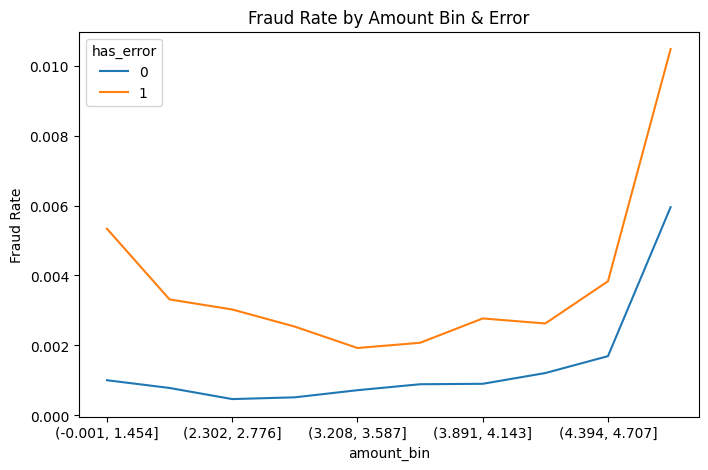

In [200]:
# error 유무별 fraud rate vs amount 구간 비교

df["amount_bin"] = pd.qcut(df["log_abs_amount"], 10, duplicates="drop")

pivot = (
    df.groupby(["amount_bin", "has_error"])["fraud"]
      .mean()
      .unstack()
)

pivot.plot(figsize=(8,5))
plt.title("Fraud Rate by Amount Bin & Error")
plt.ylabel("Fraud Rate")
plt.show()

/tmp/ipykernel_351666/4292574723.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["amount_bin", "card_error_last1"])["fraud"]


<Axes: xlabel='amount_bin'>

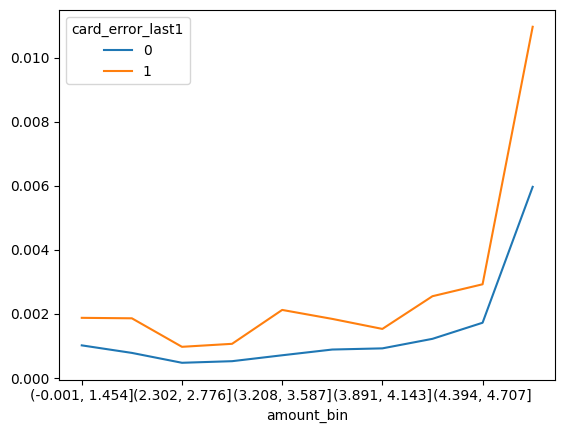

In [201]:
# 특정 error_last1에 대해 보기

pivot = (
    df.groupby(["amount_bin", "card_error_last1"])["fraud"]
      .mean()
      .unstack()
)

pivot.plot()


/tmp/ipykernel_351666/1969359812.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["amount_bin", "card_hist_x_error"])["fraud"]


<Axes: xlabel='amount_bin'>

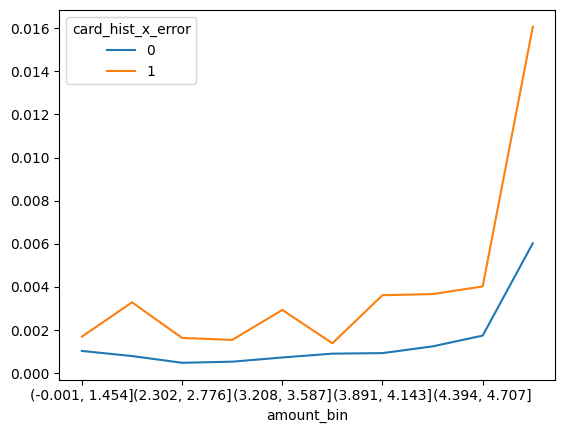

In [204]:
pivot = (
    df.groupby(["amount_bin", "card_hist_x_error"])["fraud"]
      .mean()
      .unstack()
)

pivot.plot()


/tmp/ipykernel_351666/3845558143.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["amount_bin", "client_error_last3"])["fraud"]


<Axes: xlabel='amount_bin'>

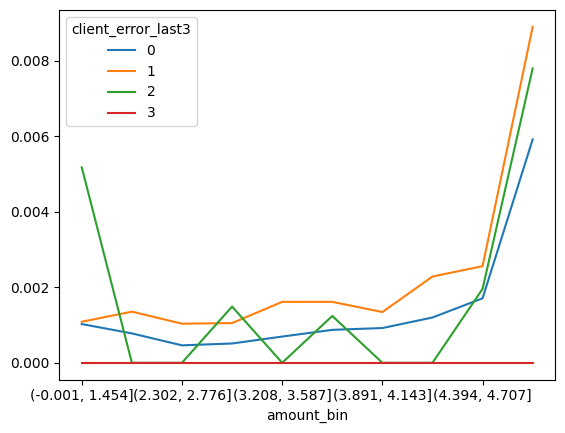

In [203]:
pivot = (
    df.groupby(["amount_bin", "client_error_last3"])["fraud"]
      .mean()
      .unstack()
)

pivot.plot()


In [220]:
error_cols = [
    "err_bad_card_number",
    "err_bad_expiration",
    "err_bad_cvv",
    "err_bad_pin",
    "err_bad_zipcode",
    "err_insufficient_balance",
    "err_technical_glitch"
]

df["error_count"] = df[error_cols].sum(axis=1)

In [222]:
df.groupby("error_count")["log_abs_amount"].mean()

error_count
0    3.350889
1    3.856803
2    4.070040
3    4.142182
Name: log_abs_amount, dtype: float32

In [221]:
df.groupby(["error_count", "fraud"])["log_abs_amount"].mean().unstack()

fraud,0,1
error_count,,
0,3.349702,4.194403
1,3.855414,4.204591
2,4.058326,5.179854
3,4.142182,NaN


In [223]:
df["error_amount_interaction"] = (
    df["error_count"] * df["log_abs_amount"]
)

In [227]:
df["amount_bin"].describe()

count            5312525
unique                10
top       (3.891, 4.143]
freq              538506
Name: amount_bin, dtype: object

/tmp/ipykernel_351666/2773820894.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("amount_bin")["fraud"]


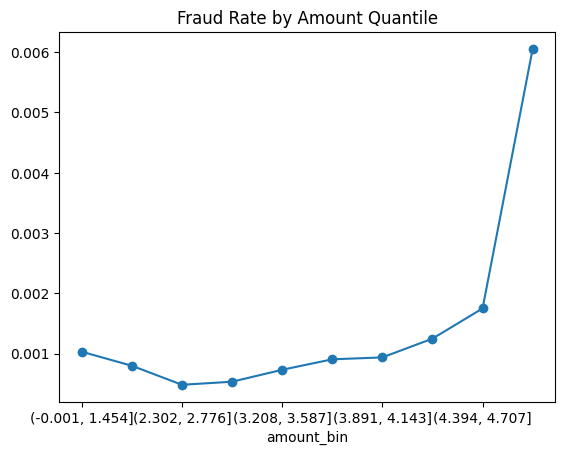

In [228]:
fraud_rate_by_bin = (
    df.groupby("amount_bin")["fraud"]
      .mean()
)

fraud_rate_by_bin.plot(marker="o")
plt.title("Fraud Rate by Amount Quantile")
plt.show()

In [229]:
base = df["fraud"].mean()

for q in [0.8, 0.85, 0.9, 0.95]:
    threshold = df["log_abs_amount"].quantile(q)
    rate = df[df["log_abs_amount"] >= threshold]["fraud"].mean()
    print(q, rate / base)


0.8 2.5631289032463065
0.85 3.2358539256023073
0.9 4.184258197220414
0.95 5.6449540882769975


In [230]:
threshold = df["log_abs_amount"].quantile(0.9)

df["high_amount"] = (df["log_abs_amount"] >= threshold).astype("int8")

df["error_high_amount"] = (
    (df["error_count"] >= 2) &
    (df["high_amount"] == 1)
).astype("int8")

In [ ]:
df["card_err1_x_amount"] = (
    df["card_error_last1"] * df["log_abs_amount"]
)

df["card_hist_err_x_amount"] = (
    df["card_hist_x_error"] * df["log_abs_amount"]
)


In [233]:
results = []

for col in ["card_err1_x_amount", "card_hist_err_x_amount", "error_high_amount"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])



,feature,coef,OR,p_value
0,card_err1_x_amount,0.228109,1.256223,3.714829e-49
1,card_hist_err_x_amount,0.317479,1.373660,2.275641e-25
2,error_high_amount,3.416196,30.453341,7.056094e-09


In [234]:
X = df[features].copy()
X = sm.add_constant(X)   

y = df["fraud"]

# 모델 학습
model = sm.Logit(y, X).fit(disp=0)

# 결과 정리
multi_df = (
    pd.DataFrame({
        "feature": model.params.index,
        "coef": model.params.values,
        "OR": np.exp(model.params.values),
        "p_value": model.pvalues.values
    })
    .sort_values("OR", ascending=False)
    .reset_index(drop=True)
)

multi_df


,feature,coef,OR,p_value
0,client_hist_x_error,0.988214,2.686431,2.585767e-28
1,card_error_last3,0.572919,1.773436,1.196669e-26
2,card_hist_x_error,0.414787,1.514049,5.052569e-03
3,client_error_last3,0.060053,1.061893,3.209967e-01
4,client_error_last1,0.031022,1.031508,7.646356e-01
5,card_error_last1,-0.046367,0.954691,6.562687e-01
6,const,-6.590582,0.001373,0.000000e+00


---

## **MCC-Based Behavioral Deviation**

## MCC History Features (Client & Card Level)

- mcc_prev
- mcc_match_last1
- mcc_seen_last3
- mcc_seen_last5
- mcc_repeat_cnt_last3
- mcc_repeat_cnt_last5
- mcc_repeat_ratio_last3
- mcc_repeat_ratio_last5
- mcc_prior_count
- mcc_is_new
- mcc_change_cnt_last5

mcc

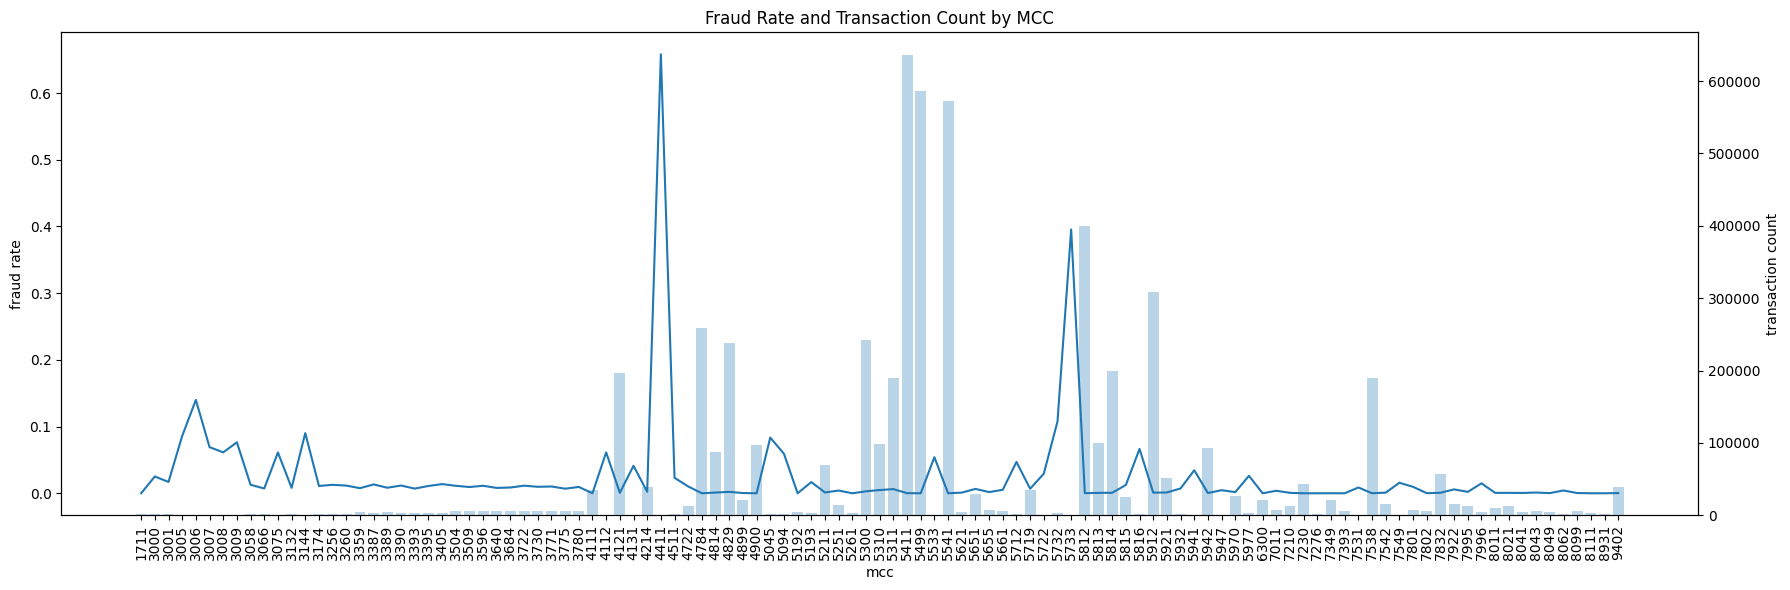

In [43]:
mcc_rate = df.groupby("mcc")["fraud"].mean()
mcc_count = df.groupby("mcc")["fraud"].count()

mcc_rate = mcc_rate.sort_index()
mcc_count = mcc_count.sort_index()

fig, ax1 = plt.subplots(figsize=(18,6))

# fraud rate
ax1.plot(mcc_rate.index.astype(str), mcc_rate.values)
ax1.set_xlabel("mcc")
ax1.set_ylabel("fraud rate")

ax1.set_xticks(range(len(mcc_rate)))
ax1.set_xticklabels(mcc_rate.index.astype(str), rotation=90)

# count
ax2 = ax1.twinx()
ax2.bar(range(len(mcc_count)), mcc_count.values, alpha=0.3)
ax2.set_ylabel("transaction count")

plt.title("Fraud Rate and Transaction Count by MCC")
plt.tight_layout()
plt.show()

In [44]:
mcc_data = pd.concat([mcc_rate, mcc_count], axis=1)
mcc_data.columns = ["fraud_rate", "tx_count"]
mcc_data = mcc_data.sort_values("fraud_rate", ascending=False)
mcc_data.head(100)

,fraud_rate,tx_count
mcc,,
4411,0.658163,196
5733,0.395522,134
3006,0.140000,150
5732,0.107561,2817
3144,0.090164,122
3005,0.085890,163
5045,0.083486,1090
3009,0.076389,144
3007,0.069182,159


- 4411: Cruise Lines
- 5733: Music Stores - Musical Instruments
- 3006: Miscellaneous Fabricated Metal Products

| mcc  | fraud_rate | tx_count | mcc |
| ---- | ---------- | -------- | -------- |
| 5732 | 0.107      | 2817     | Electronics Stores |
| 5045 | 0.083      | 1090     | Computers, Computer Peripheral Equipment |
| 5816 | 0.066      | 1143     | Digital Goods - Games |
| 5094 | 0.059      | 2077     | Precious Stones and Metals |
| 5712 | 0.046      | 1511     | Furniture, Home Furnishings, and Equipment Stores |


- 5732 — Electronics Stores

        전자제품 = 고가 + 재판매 용이 + 온라인 결제 빈번
        → 전형적인 카드 부정 사용 업종

- 5045 — Computers & Peripherals

        노트북, GPU, 부품
        → 고가 + 현금화 쉬움

- 5816 — Digital Goods (Games)

        디지털 아이템 = 배송 없음 + 즉시 소비
        → 도난 카드로 빠르게 전환 가능

- 5094 — Precious Stones & Metals

        금, 귀금속
        → 가치 저장 + 환금성

- 5712 — Furniture / Home Furnishing

        예상 외 결과

In [45]:
high_risk_mcc = ["5732", "5045", "5816", "5094", "5712"]

df["is_highrisk_mcc"] = df["mcc"].isin(high_risk_mcc).astype("int8")

**5732_Electronics Stores**

In [46]:
ES = df[df["mcc"]=="5732"].copy()

when

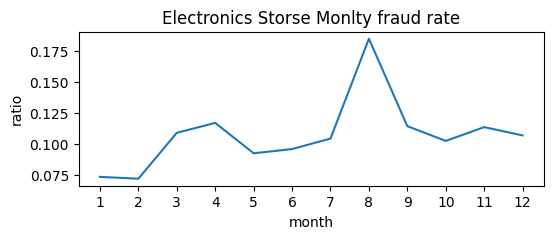

In [48]:
month = (
    ES
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(6,2))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Electronics Storse Monlty fraud rate")
plt.show()

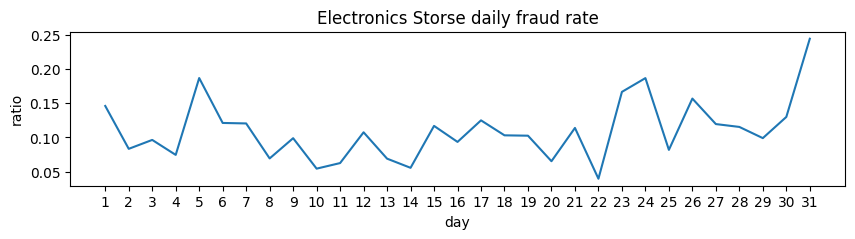

In [50]:
day = (
    ES
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(10,2))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Electronics Storse daily fraud rate")
plt.show()

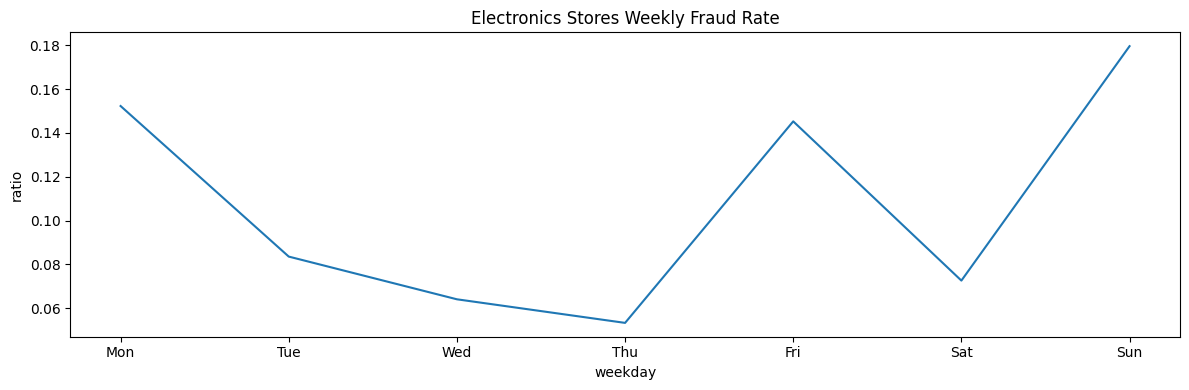

In [54]:
weekday_map = {
    0: "Mon",
    1: "Tue",
    2: "Wed",
    3: "Thu",
    4: "Fri",
    5: "Sat",
    6: "Sun"
}

ES["weekday_name"] = ES["weekday"].map(weekday_map)

order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

week = (
    ES
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
week.plot()

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Electronics Stores Weekly Fraud Rate")
plt.tight_layout()
plt.show()


refund

In [55]:
refund = (
    ES
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.107561
Name: fraud, dtype: float64

log_abs_amount

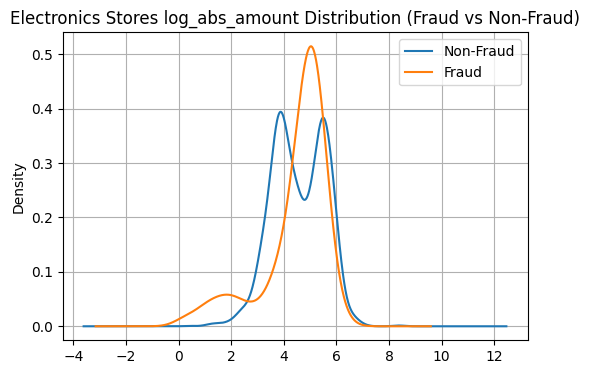

In [58]:
plt.figure(figsize=(6,4))
ES[ES["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
ES[ES["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Electronics Stores log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [59]:
ES.groupby("fraud")["is_credit"].mean()

fraud
0    0.403739
1    0.316832
Name: is_credit, dtype: float64

In [60]:
ES.groupby("fraud")["is_prepaid"].mean()

fraud
0    0.043357
1    0.118812
Name: is_prepaid, dtype: float64

대다수 fraud는 prepaid되지 않은 체크카드 _ 다중공선성 문제 있을까봐 is_depit(non prepaid)는 컬럼에 없음 주의

In [61]:
ES.groupby(["is_credit","is_prepaid"])["fraud"].mean()

is_credit  is_prepaid
0          0             0.109545
           1             0.248276
1          0             0.086409
Name: fraud, dtype: float64

**5045_Computers, Computer Peripheral Equipment**

when

In [63]:
C = df[df["mcc"]=="5045"].copy()

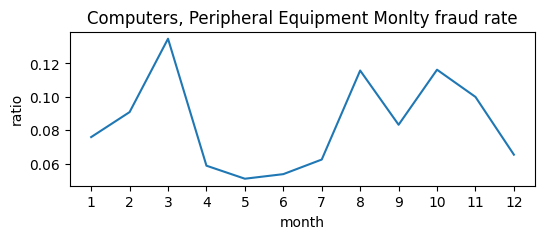

In [64]:
month = (
    C
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(6,2))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Monlty fraud rate")
plt.show()

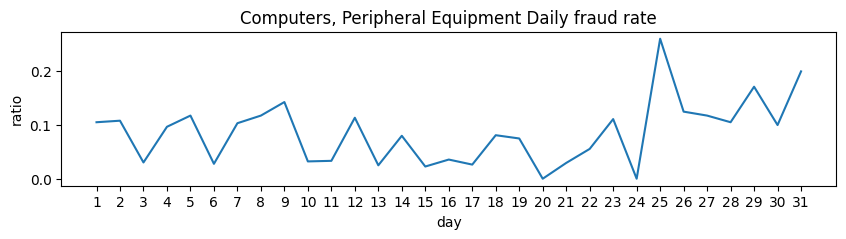

In [66]:
day = (
    C
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(10,2))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Daily fraud rate")
plt.show()

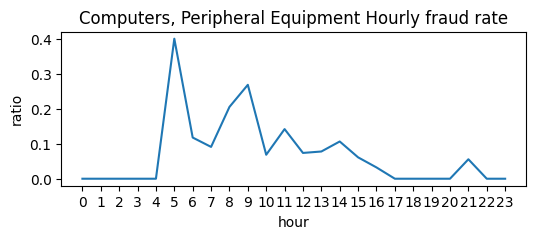

In [67]:
hour = (
    C
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(6,2))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Hourly fraud rate")
plt.show()

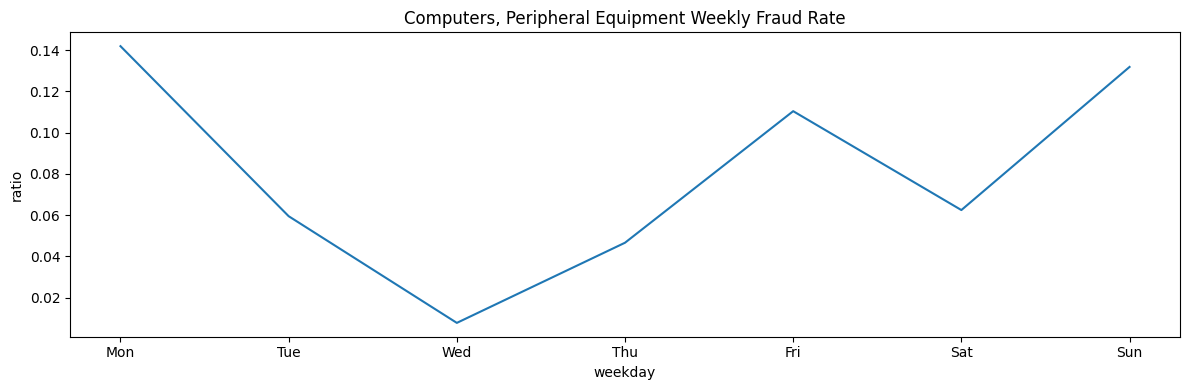

In [68]:
C["weekday_name"] = C["weekday"].map(weekday_map)

order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

week = (
    C
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
week.plot()

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Computers, Peripheral Equipment Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [69]:
refund = (
    C
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.083486
Name: fraud, dtype: float64

log_abs_amount

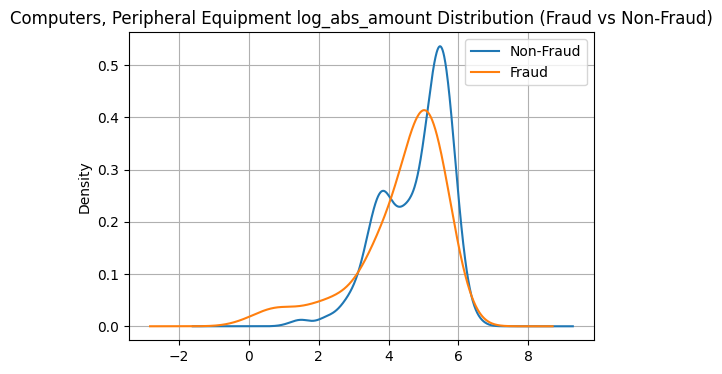

In [71]:
plt.figure(figsize=(6,4))
C[C["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
C[C["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Computers, Peripheral Equipment log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [73]:
print(C.groupby("is_credit")["fraud"].mean())
print(C.groupby("is_prepaid")["fraud"].mean())

is_credit
0    0.105096
1    0.054113
Name: fraud, dtype: float64
is_prepaid
0    0.076923
1    0.270270
Name: fraud, dtype: float64


**5816_Digital Goods - Games**

In [74]:
DG = df[df["mcc"]=="5816"].copy()

when

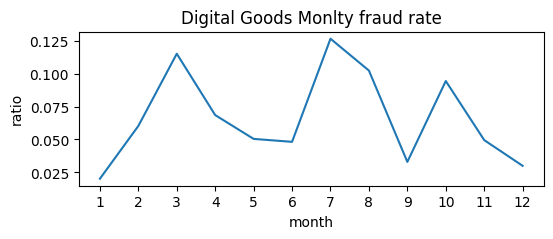

In [75]:
month = (
    DG
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(6,2))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Digital Goods Monlty fraud rate")
plt.show()

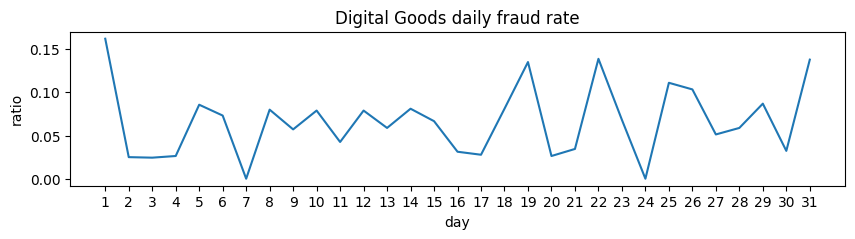

In [77]:
day = (
    DG
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(10,2))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Digital Goods daily fraud rate")
plt.show()

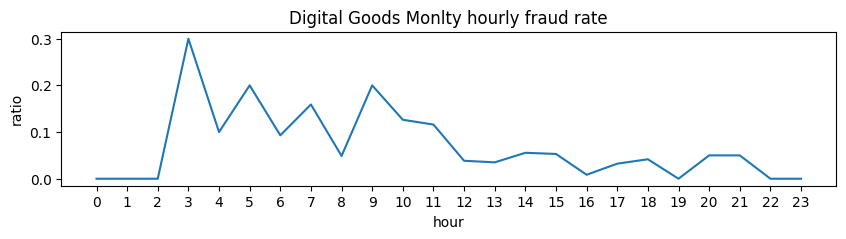

In [78]:
hour = (
    DG
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(10, 2))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Digital Goods Monlty hourly fraud rate")
plt.show()

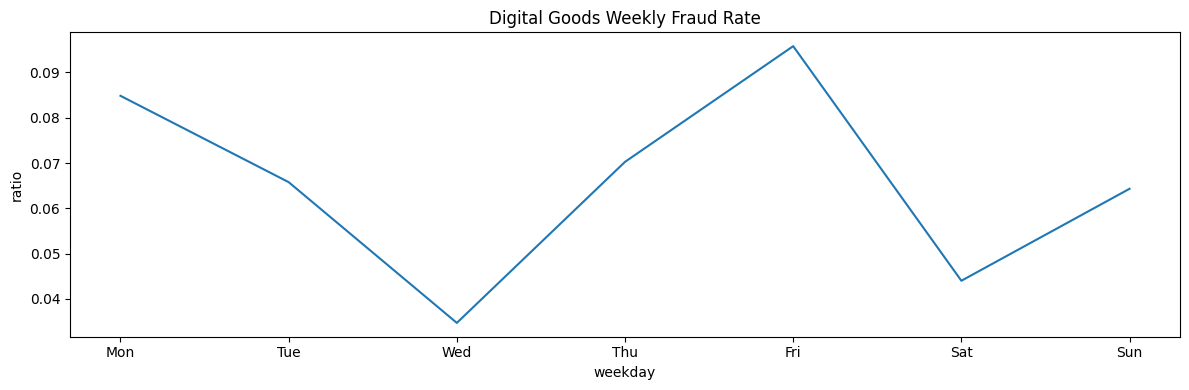

In [79]:
DG["weekday_name"] = DG["weekday"].map(weekday_map)

week = (
    DG
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
week.plot()

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Digital Goods Weekly Fraud Rate")
plt.tight_layout()
plt.show()

In [80]:
refund = (
    DG
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.066492
Name: fraud, dtype: float64

log_abs_amount

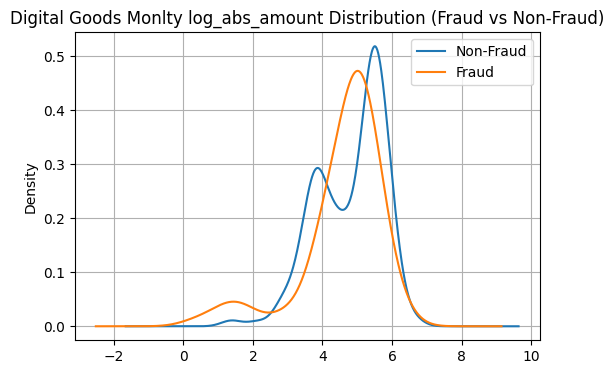

In [81]:
plt.figure(figsize=(6,4))
DG[DG["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
DG[DG["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Digital Goods Monlty log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [83]:
print(DG.groupby("is_credit")["fraud"].mean())
print()
print(DG.groupby("is_prepaid")["fraud"].mean())

is_credit
0    0.080997
1    0.047904
Name: fraud, dtype: float64

is_prepaid
0    0.062893
1    0.200000
Name: fraud, dtype: float64


**5094_Precious Stones and Metals**

In [84]:
SM = df[df["mcc"]=="5094"].copy()

when

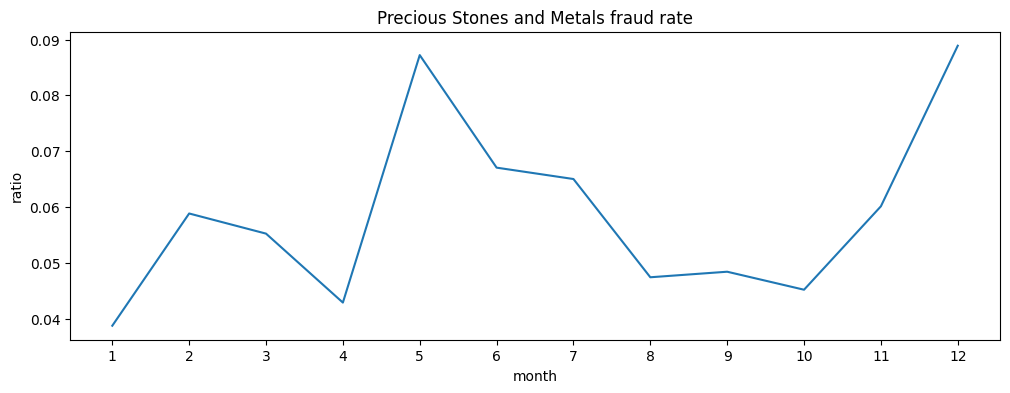

In [87]:
month = (
    SM
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals fraud rate")
plt.show()

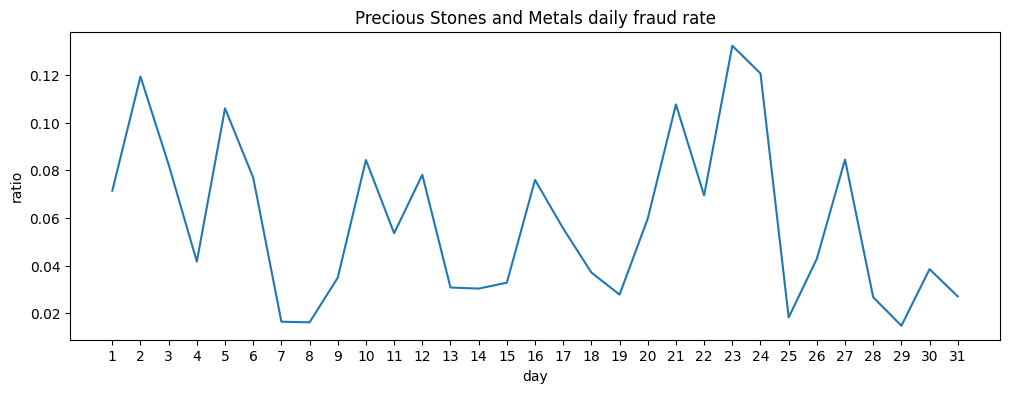

In [88]:
day = (
    SM
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals daily fraud rate")
plt.show()

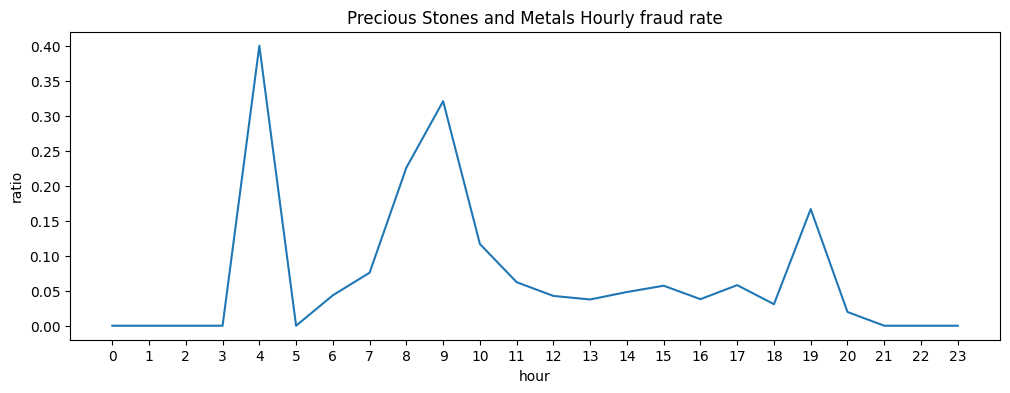

In [89]:
hour = (
    SM
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(12,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals Hourly fraud rate")
plt.show()

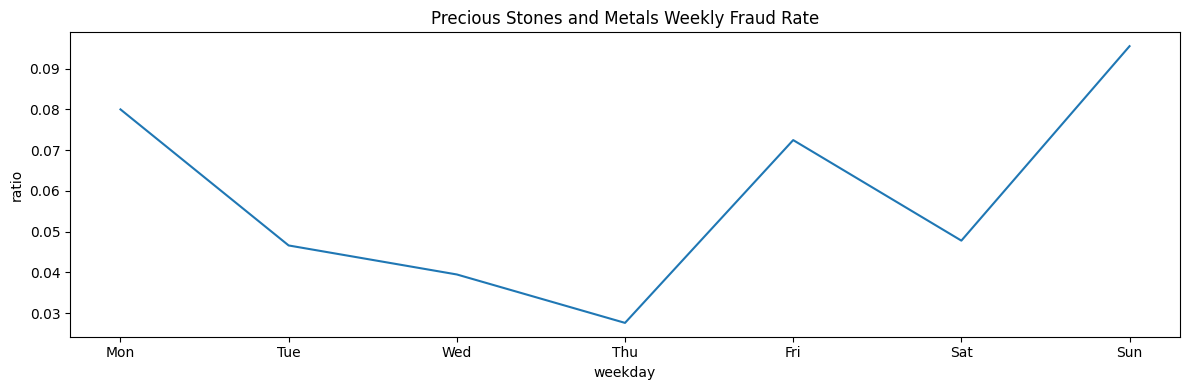

In [90]:
SM["weekday_name"] = SM["weekday"].map(weekday_map)

week = (
    SM
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
week.plot()

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Precious Stones and Metals Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [91]:
refund = (
    SM
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.05922
Name: fraud, dtype: float64

log_abs_amount

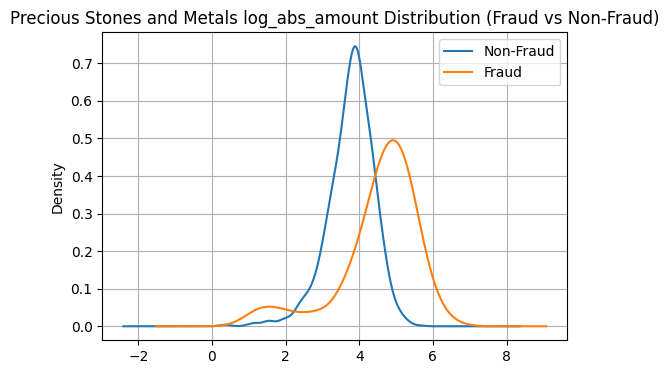

In [92]:
plt.figure(figsize=(6,4))
SM[SM["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
SM[SM["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Precious Stones and Metals log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [93]:
print(SM.groupby("is_credit")["fraud"].mean())
print()
print(SM.groupby("is_prepaid")["fraud"].mean())

is_credit
0    0.061608
1    0.054960
Name: fraud, dtype: float64

is_prepaid
0    0.052495
1    0.143791
Name: fraud, dtype: float64


**5712_Furniture, Home Furnishings, and Equipment Stores**

In [94]:
F = df[df["mcc"]=="5712"].copy()

when

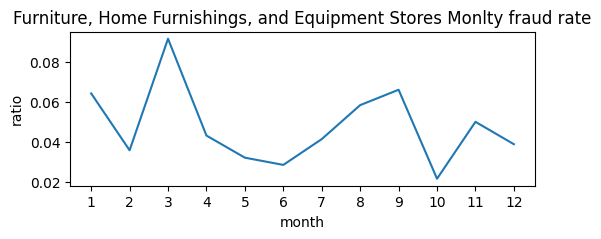

In [95]:
month = (
    F
    .groupby("tx_month")[LABEL]
    .mean()
)
plt.figure(figsize=(6,2))
month.plot()
plt.xticks(month.index)
plt.xlabel("month")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Monlty fraud rate")
plt.show()

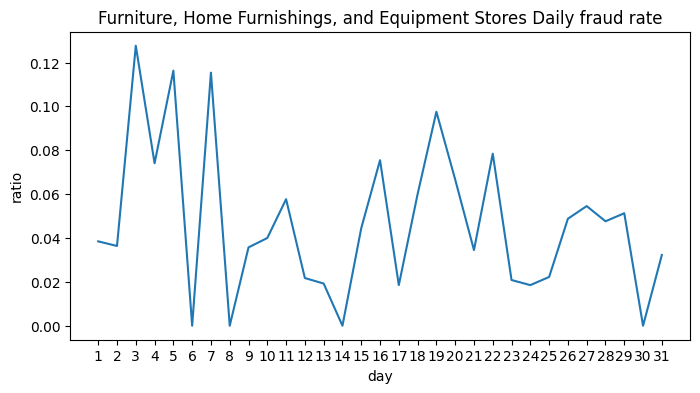

In [96]:
day = (
    F
    .groupby("tx_day")[LABEL]
    .mean()
)
plt.figure(figsize=(8,4))
day.plot()
plt.xticks(day.index)
plt.xlabel("day")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Daily fraud rate")
plt.show()

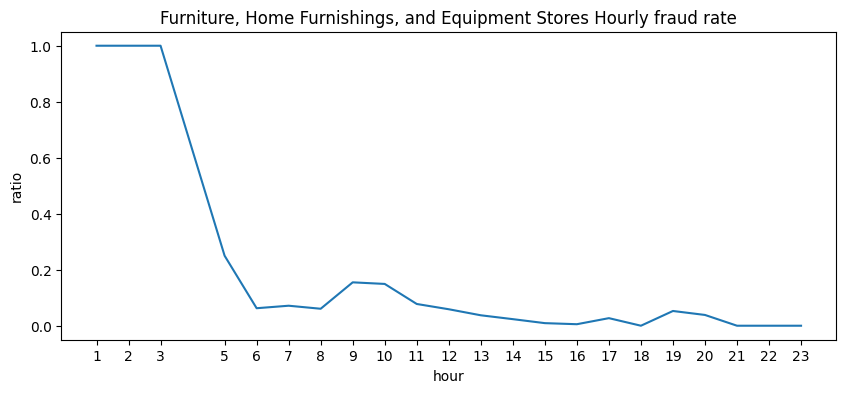

In [98]:
hour = (
    F
    .groupby("tx_hour")[LABEL]
    .mean()
)
plt.figure(figsize=(10,4))
hour.plot()
plt.xticks(hour.index)
plt.xlabel("hour")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Hourly fraud rate")
plt.show()

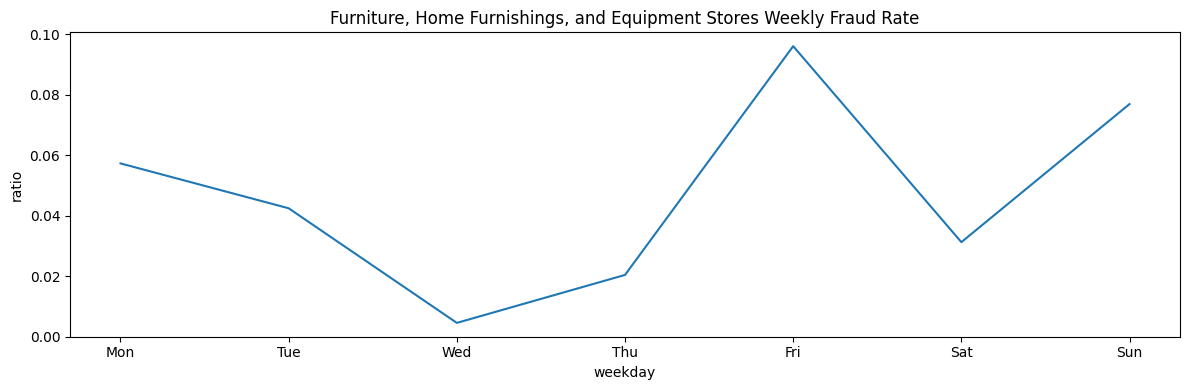

In [99]:
F["weekday_name"] = F["weekday"].map(weekday_map)

week = (
    F
    .groupby("weekday_name")[LABEL]
    .mean()
    .reindex(order)
)

plt.figure(figsize=(12,4))
week.plot()

plt.xlabel("weekday")
plt.ylabel("ratio")
plt.title("Furniture, Home Furnishings, and Equipment Stores Weekly Fraud Rate")
plt.tight_layout()
plt.show()

is_refund

In [100]:
refund = (
    F
    .groupby("is_refund")[LABEL]
    .mean()
)
refund

is_refund
0    0.046989
Name: fraud, dtype: float64

log_abs_amount

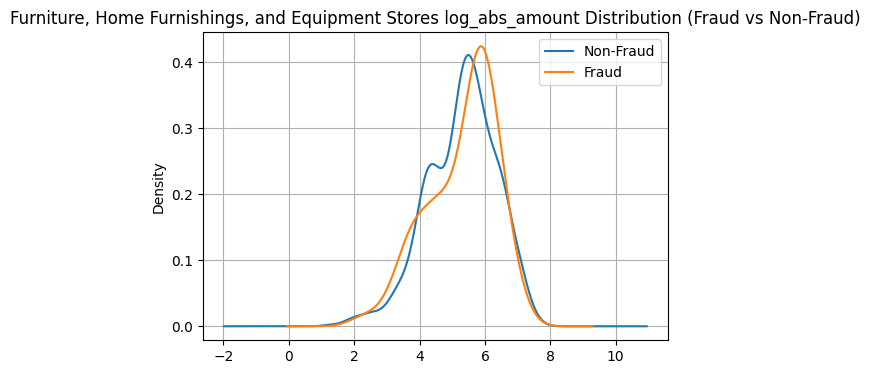

In [101]:
plt.figure(figsize=(6,4))
F[F["fraud"] == 0]["log_abs_amount"].plot(kind="kde", label="Non-Fraud")
F[F["fraud"] == 1]["log_abs_amount"].plot(kind="kde", label="Fraud")
plt.title(f"Furniture, Home Furnishings, and Equipment Stores log_abs_amount Distribution (Fraud vs Non-Fraud)")
plt.legend()
plt.grid(True)
plt.show()

is_credit / debit(prepaid) / debit

In [103]:
print(F.groupby("is_credit")["fraud"].mean())
print()
print(F.groupby("is_prepaid")["fraud"].mean())

is_credit
0    0.061893
1    0.029112
Name: fraud, dtype: float64

is_prepaid
0    0.044685
1    0.147059
Name: fraud, dtype: float64


> “주요 MCC 대부분 아침 시간대에 주로 발생”\
> → 노트북의 MCC별 tx_hour fraud rate 그래프 + “When 메모(아침/새벽~오전)”가 그 방향으로 정리돼 있음.

> “요일은 대부분 금·일 피크”\
> → MCC별 weekday_name fraud rate도 동일 템플릿으로 확인하는 구조라서, “전역 요일 패턴이 MCC별로도 유지되는지”를 재확인한 셈.

> “fraud는 debit(non_prepaid)가 가장 높다”\
> → MCC 5개 전부에서 fraud의 is_credit 평균이 낮아지고, prepaid는 오르긴 하지만 절대값이 크지 않아서 최종적으로 non-prepaid debit 쏠림 결론이 일관됨.

| 항목          | 유의미성 |
| ----------- | ---- |
| 아침 fraud 집중 | 중간   |
| 금·일 피크      | 중간   |
| debit 우세    | 약~중간 |
| MCC별 일관성    | 흥미로움 |

In [104]:
high_risk_days = [0, 4, 6]

df["is_highrisk_weekday"] = df["weekday"].isin(high_risk_days).astype("int8")

단변량 검증

In [105]:
results = []

for col in ["is_highrisk_weekday",
            "is_highrisk_mcc"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,is_highrisk_weekday,0.599875,1.821890,1.569519e-148
1,is_highrisk_mcc,4.139878,62.795148,0.000000e+00


다변량 검증

In [108]:
cols = ["is_highrisk_weekday","is_highrisk_mcc"]
tmp = df[cols + ["fraud"]].dropna()

X = sm.add_constant(tmp[cols])
y = tmp["fraud"]

model = sm.Logit(y, X).fit(disp=0)

multi_df = pd.DataFrame({
    "feature": model.params.index,
    "coef": model.params.values,
    "OR": np.exp(model.params.values),
    "p_value": model.pvalues.values
}).sort_values("OR", ascending=False)

multi_df

,feature,coef,OR,p_value
2,is_highrisk_mcc,4.142261,62.944985,0.000000e+00
1,is_highrisk_weekday,0.601232,1.824365,3.008658e-148
0,const,-6.928627,0.000979,0.000000e+00


In [109]:
df["is_highrisk_mcc"].mean()


np.float64(0.0016259688189702638)

In [115]:
# 0) 유틸: lift 테이블
def make_lift_table(y_true, score, n_bins=10):
    eval_df = pd.DataFrame({"y": y_true.astype(int), "score": score}).copy()

    eval_df["bin"] = pd.qcut(eval_df["score"], q=n_bins, labels=False, duplicates="drop")

    base_rate = eval_df["y"].mean()

    tab = (
        eval_df.groupby("bin")["y"]
        .agg(count="count", sum="sum", mean="mean")
        .sort_index(ascending=False)
    )
    tab["lift"] = tab["mean"] / base_rate if base_rate > 0 else np.nan
    tab["base_rate"] = base_rate
    return tab


# 1) 시간 분리
train = df[df["tx_year"] < 2015].copy()
test  = df[df["tx_year"] == 2015].copy()

# sanity check
print("train shape:", train.shape, "fraud rate:", train["fraud"].mean())
print("test  shape:", test.shape,  "fraud rate:", test["fraud"].mean())



# 2) train에서 highrisk_mcc 정의 
MIN_TX = 200  
TOP_PCT = 0.95  

mcc_stats = (
    train.groupby("mcc")["fraud"]
    .agg(tx_count="size", fraud_rate="mean")
)

mcc_stats = mcc_stats[mcc_stats["tx_count"] >= MIN_TX].copy()

# 유효 mcc가 너무 적으면 조건 완화
if len(mcc_stats) < 10:
    print("valid mcc count:", len(mcc_stats))

thr = mcc_stats["fraud_rate"].quantile(TOP_PCT)
highrisk_mcc_set = set(mcc_stats.loc[mcc_stats["fraud_rate"] >= thr].index)

print("highrisk_mcc_set size:", len(highrisk_mcc_set))
print("train highrisk share:", train["mcc"].isin(highrisk_mcc_set).mean())
print("test  highrisk share:", test["mcc"].isin(highrisk_mcc_set).mean())

train["is_highrisk_mcc"] = train["mcc"].isin(highrisk_mcc_set).astype("int8")
test["is_highrisk_mcc"]  = test["mcc"].isin(highrisk_mcc_set).astype("int8")



# 3) test에서 로지스틱 평가

features = ["is_highrisk_mcc"]

tmp = test[features + ["fraud"]].dropna().copy()

if tmp.shape[0] == 0:
    raise ValueError(
        "test에서 features+fraud dropna 후 데이터가 0개야. "
        "is_highrisk_mcc가 제대로 만들어졌는지, test에 fraud가 있는지 확인해."
    )

y = tmp["fraud"].astype(int)

X = sm.add_constant(tmp[features], has_constant="add")

try:
    model_test = sm.Logit(y, X).fit(disp=0)
except Exception as e:
    print("[ERROR] Logit fitting failed:", repr(e))
    print("highrisk_mcc value counts in test:")
    print(tmp["is_highrisk_mcc"].value_counts(dropna=False))
    print("fraud counts in test:")
    print(y.value_counts(dropna=False))
    raise

# OR 테이블
result_test = pd.DataFrame({
    "feature": model_test.params.index,
    "coef": model_test.params.values,
    "OR": np.exp(model_test.params.values),
    "p_value": model_test.pvalues.values
}).sort_values("OR", ascending=False)

print("\n[TEST OR RESULTS]")
print(result_test)

# 4) test Lift 계산

score = model_test.predict(X)
lift_test = make_lift_table(y, score, n_bins=10)

print("\n[TEST LIFT TABLE]")
print(lift_test)

top_bin = lift_test.index.max()
print("\n[TEST TOP-DECILE SUMMARY]")
print({
    "base_rate": float(lift_test.loc[top_bin, "base_rate"]),
    "top_decile_rate": float(lift_test.loc[top_bin, "mean"]),
    "top_decile_lift": float(lift_test.loc[top_bin, "lift"]),
})


train shape: (4386257, 56) fraud rate: 0.0012566523119826312
test  shape: (926268, 56) fraud rate: 0.0023492121070791605
highrisk_mcc_set size: 5
train highrisk share: 0.0011994281228847284
test  highrisk share: 0.0012793273652981641

[TEST OR RESULTS]
           feature      coef         OR  p_value
1  is_highrisk_mcc  4.054086  57.632484      0.0
0            const -6.113744   0.002212      0.0

[TEST LIFT TABLE]
      count   sum      mean  lift  base_rate
bin                                         
0    926268  2176  0.002349   1.0   0.002349

[TEST TOP-DECILE SUMMARY]
{'base_rate': 0.0023492121070791605, 'top_decile_rate': 0.0023492121070791605, 'top_decile_lift': 1.0}


In [116]:
tmp = test[["is_highrisk_mcc", "fraud"]].copy()

base_rate = tmp["fraud"].mean()

grp = (
    tmp.groupby("is_highrisk_mcc")["fraud"]
    .agg(count="count", sum="sum", mean="mean")
)

grp["lift_vs_base"] = grp["mean"] / base_rate
grp["base_rate"] = base_rate

grp

,count,sum,mean,lift_vs_base,base_rate
is_highrisk_mcc,,,,,
0,925083,2042,0.002207,0.939621,0.002349
1,1185,134,0.113080,48.135359,0.002349


highrisk_mcc는 시간 넘어가도 여전히 강력한 세그먼트\
fraud 2176건 중 134건만 잡음 -> 단독 피처 위험

is highrisk mcc -> 다른 변수들을 통제해도 독립적 강한 신호

low income flag 제거 후보



In [129]:
def lift_table(y_true, score, n_bins=10):
    eval_df = pd.DataFrame({"y": y_true.astype(int), "score": score}).copy()
    if len(eval_df) == 0:
        return pd.DataFrame(columns=["count","sum","mean","lift","base_rate"])

    # 점수 중복 많아도 돌아가게
    eval_df["bin"] = pd.qcut(eval_df["score"], q=n_bins, labels=False, duplicates="drop")

    base_rate = eval_df["y"].mean()
    tab = (
        eval_df.groupby("bin")["y"]
        .agg(count="count", sum="sum", mean="mean")
        .sort_index(ascending=False)
    )
    tab["lift"] = tab["mean"] / base_rate if base_rate > 0 else np.nan
    tab["base_rate"] = base_rate
    return tab


def fit_logit(df_in, features, y_col="fraud"):
    tmp = df_in[features + [y_col]].dropna(subset=features + [y_col]).copy()
    X = sm.add_constant(tmp[features], has_constant="add")
    y = tmp[y_col].astype(int)

    # statsmodels용 숫자 보장
    X = X.apply(pd.to_numeric, errors="raise")

    model = sm.Logit(y, X).fit(disp=0)
    return model


features_no_rule = [
    "tx_month",
    "tx_day",
    "tx_hour",
    "weekday",
    "log_abs_amount",
    "log_amount_limit_ratio",
    "log_yearly_income",
]

# 1) train fit
model_nr = fit_logit(train, features_no_rule, y_col="fraud")

# 2) test 준비 
tmp_test = test[features_no_rule + ["fraud"]].dropna(subset=features_no_rule + ["fraud"]).copy()
print("tmp_test rows =", len(tmp_test))
print(tmp_test[features_no_rule].isna().sum().sort_values(ascending=False).head(10))

if len(tmp_test) == 0:
    missing = test[features_no_rule + ["fraud"]].isna().sum().sort_values(ascending=False)
    raise ValueError("tmp_test가 0행임. 결측 컬럼 상위:\n" + missing.to_string())

X_test = sm.add_constant(tmp_test[features_no_rule], has_constant="add")
X_test = X_test.apply(pd.to_numeric, errors="raise")
y_test = tmp_test["fraud"].astype(int)  # ★반드시 tmp_test에서 뽑기

# 3) predict + lift
score_nr = model_nr.predict(X_test)
lift_nr = lift_table(y_test, score_nr, n_bins=10)

score_nr.head(), lift_nr

tmp_test rows = 926268
tx_month                  0
tx_day                    0
tx_hour                   0
weekday                   0
log_abs_amount            0
log_amount_limit_ratio    0
log_yearly_income         0
dtype: int64


(4402755    0.003145
 4402756    0.004080
 4402757    0.004201
 4402758    0.002504
 4402759    0.003121
 dtype: float64,
      count  sum      mean      lift  base_rate
 bin                                           
 9    92627  726  0.007838  3.336390   0.002349
 8    92627  335  0.003617  1.539519   0.002349
 7    92627  290  0.003131  1.332718   0.002349
 6    92626  192  0.002073  0.882361   0.002349
 5    92627  144  0.001555  0.661763   0.002349
 4    92627  113  0.001220  0.519300   0.002349
 3    92626   85  0.000918  0.390628   0.002349
 2    92627   60  0.000648  0.275735   0.002349
 1    92627   69  0.000745  0.317095   0.002349
 0    92627  162  0.001749  0.744484   0.002349)

In [132]:
features_full = [
    # time
    "tx_month","tx_day","tx_hour","weekday",
    # money/income
    "log_abs_amount","log_amount_limit_ratio","log_yearly_income",
    # rules
    "is_highrisk_mcc","is_highrisk_weekday",
]

model_full = fit_logit(train, features_full, y_col="fraud")

tmp_test_full = test[features_full + ["fraud"]].dropna().copy()
print("tmp_test_full rows =", len(tmp_test_full))

X_test_full = sm.add_constant(tmp_test_full[features_full], has_constant="add")
X_test_full = X_test_full.apply(pd.to_numeric, errors="raise")
y_test_full = tmp_test_full["fraud"].astype(int)

score_full = model_full.predict(X_test_full)
lift_full = lift_table(y_test_full, score_full)

lift_full


tmp_test_full rows = 926268


,count,sum,mean,lift,base_rate
bin,,,,,
9,92627,825,0.008907,3.791352,0.002349
8,92627,348,0.003757,1.599261,0.002349
7,92627,248,0.002677,1.139703,0.002349
6,92626,184,0.001986,0.845596,0.002349
5,92627,135,0.001457,0.620403,0.002349
4,92627,103,0.001112,0.473345,0.002349
3,92626,76,0.000821,0.349268,0.002349
2,92627,48,0.000518,0.220588,0.002349
1,92627,79,0.000853,0.363051,0.002349


✅ no-rule 모델

top decile fraud rate = 0.007838\
top decile lift = 3.34

✅ full 모델 (highrisk_mcc + weekday 포함)

top decile fraud rate = 0.008907\
top decile lift = 3.79

=> highrisk_mcc를 넣으면 top decile lift가 약 13% 개선

no 과적합

재학습 필요!

In [134]:
# 하드코딩 버려야 함!!! 

def add_is_highrisk_mcc(
    df: pd.DataFrame,
    y_col: str = "fraud",
    mcc_col: str = "mcc",
    year_col: str = "tx_year",
    cutoff_year: int = 2015,   
    top_pct: float = 0.95,   
    min_tx: int = 200       
):
    # 1) 정의용 구간(=train 역할)만 사용
    base = df[df[year_col] <= cutoff_year].copy()

    # 2) mcc별 통계 (거래수, fraud_rate)
    stats = (
        base.groupby(mcc_col)[y_col]
        .agg(tx_count="size", fraud_rate="mean")
        .sort_values("fraud_rate", ascending=False)
    )

    # 3) 안정성: 표본 너무 적은 mcc 제거
    stats = stats[stats["tx_count"] >= min_tx].copy()

    if len(stats) == 0:
        raise ValueError("min_tx 조건 때문에 유효 mcc가 0개")

    # 4) fraud_rate 상위 top_pct 기준으로 highrisk 선정
    thr = stats["fraud_rate"].quantile(top_pct)
    highrisk_mcc_list = stats.loc[stats["fraud_rate"] >= thr].index.tolist()

    # 5) df 전체에 적용 (정의는 train 기준, 적용은 전체)
    df = df.copy()
    df["is_highrisk_mcc"] = df[mcc_col].isin(highrisk_mcc_list).astype("int8")

    # 참고용: 리턴값으로 리스트/통계 같이 반환
    return df, highrisk_mcc_list, stats, thr

cands = [0.90, 0.95, 0.97, 0.99]
out = []

for tp in cands:
    tmp_df, lst, _, _ = add_is_highrisk_mcc(df, cutoff_year=2015, top_pct=tp, min_tx=200)
    out.append([tp, len(lst), tmp_df["is_highrisk_mcc"].mean()])

pd.DataFrame(out, columns=["top_pct", "n_mcc", "highrisk_share"]).sort_values("top_pct", ascending=False)

,top_pct,n_mcc,highrisk_share
3,0.99,1,0.000530
2,0.97,3,0.000951
1,0.95,5,0.001510
0,0.90,10,0.002643


In [141]:
def topk_lift(y_true, score, top_frac=0.10):

    y = np.asarray(y_true, dtype=int)
    s = np.asarray(score, dtype=float)

    base_rate = y.mean()
    if len(y) == 0:
        return np.nan, np.nan, np.nan, 0

    # 상위 top_frac 컷
    q = 1.0 - top_frac
    thr = np.quantile(s, q)

    top_mask = s >= thr
    top_n = int(top_mask.sum())

    # 극단 케이스 방어
    if top_n == 0:
        return np.nan, np.nan, base_rate, 0
    if top_n == len(s):
        # 점수가 전부 동일하면 전체가 top으로 잡힘 -> lift=1
        return 1.0, base_rate, base_rate, top_n

    top_rate = y[top_mask].mean()
    lift = top_rate / base_rate if base_rate > 0 else np.nan
    return lift, top_rate, base_rate, top_n


def make_highrisk_mcc_flag(df, cutoff_year=2015, top_pct=0.95, min_tx=200):
    base = df[df["tx_year"] <= cutoff_year]

    stats = (
        base.groupby("mcc")["fraud"]
        .agg(tx_count="size", fraud_rate="mean")
    )
    stats = stats[stats["tx_count"] >= min_tx]
    if len(stats) == 0:
        raise ValueError(f"유효 mcc가 0개야. min_tx({min_tx})를 낮춰.")

    thr = stats["fraud_rate"].quantile(top_pct)
    highrisk_list = stats.loc[stats["fraud_rate"] >= thr].index.tolist()

    out = df.copy()
    out["is_highrisk_mcc"] = out["mcc"].isin(highrisk_list).astype("int8")
    return out, highrisk_list


def fit_logit(df_in, features):
    tmp = df_in[features + ["fraud"]].dropna()
    X = sm.add_constant(tmp[features], has_constant="add")
    X = X.apply(pd.to_numeric, errors="raise")
    y = tmp["fraud"].astype(int)
    model = sm.Logit(y, X).fit(disp=0)
    return model


TOPS = [0.99, 0.97, 0.95, 0.90]

features_full = [
    "tx_month","tx_day","tx_hour","weekday",
    "log_abs_amount","log_amount_limit_ratio","log_yearly_income",
    "is_highrisk_mcc","is_highrisk_weekday",
]

rows = []

for tp in TOPS:
    # (A) highrisk_mcc를 train(<=2014) 기준으로 생성
    df_tmp, highrisk_list = make_highrisk_mcc_flag(df, cutoff_year=2015, top_pct=tp, min_tx=200)

    # (B) split
    train_df = df_tmp[df_tmp["tx_year"] <= 2014]
    test_df  = df_tmp[df_tmp["tx_year"] == 2015]

    # (C) fit
    model = fit_logit(train_df, features_full)

    # (D) test score
    tmp_test = test_df[features_full + ["fraud"]].dropna()
    X_test = sm.add_constant(tmp_test[features_full], has_constant="add").apply(pd.to_numeric, errors="raise")
    y_test = tmp_test["fraud"].astype(int).values
    score = model.predict(X_test).values

    # (E) robust top10% lift
    lift, top_rate, base_rate, top_n = topk_lift(y_test, score, top_frac=0.10)

    rows.append({
        "top_pct": tp,
        "n_mcc": len(highrisk_list),
        "highrisk_share": float(df_tmp["is_highrisk_mcc"].mean()),
        "top10_n": int(top_n),
        "base_rate": float(base_rate),
        "top10_rate": float(top_rate) if top_rate == top_rate else np.nan,
        "top10_lift": float(lift) if lift == lift else np.nan,
    })

summary_df = pd.DataFrame(rows).sort_values("top10_lift", ascending=False).reset_index(drop=True)
summary_df


,top_pct,n_mcc,highrisk_share,top10_n,base_rate,top10_rate,top10_lift
0,0.90,10,0.002643,92627,0.002349,0.009360,3.984366
1,0.95,5,0.001510,92627,0.002349,0.009079,3.864881
2,0.97,3,0.000951,92627,0.002349,0.008680,3.694845
3,0.99,1,0.000530,92627,0.002349,0.008658,3.685654


In [142]:
base_rate = df["fraud"].mean()

mcc_stats = (
    df.groupby("mcc")["fraud"]
      .agg(["mean", "count"])
      .rename(columns={"mean":"fraud_rate", "count":"tx_count"})
)

highrisk_mcc = mcc_stats[
    (mcc_stats["tx_count"] >= 1000) &
    (mcc_stats["fraud_rate"] >= base_rate * 3)
].index.tolist()

df["mcc_highrisk_90"] = df["mcc"].isin(highrisk_mcc).astype("int8")

---
## Merchant Novelty
- client_merchant_is_new
- card_merchant_is_new
- merchant_change_cnt_last5
- merchant_is_new × mcc_is_new
- merchant_is_new × has_error
- merchant_is_new × velocity_spike_ratio

---

## **Temporal Deviation Features**

## Time-of-Day Drift
- hour_sin, hour_cos
- client_hour_sin_avg
- client_hour_cos_avg
- hour_deviation

### yearly transasctions

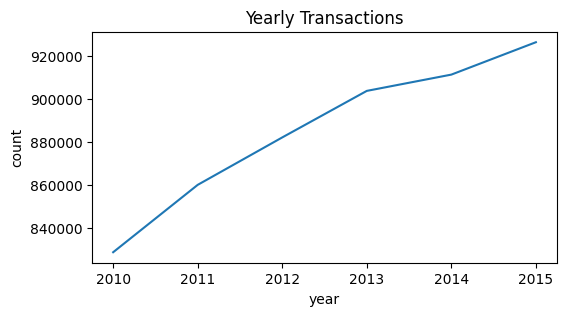

In [ ]:
yearly = df["tx_year"].value_counts()

plt.figure(figsize=(6,3))
yearly.plot()
plt.title("Yearly Transactions")
plt.xlabel("year")
plt.ylabel("count")
plt.show()

### yearly fraud

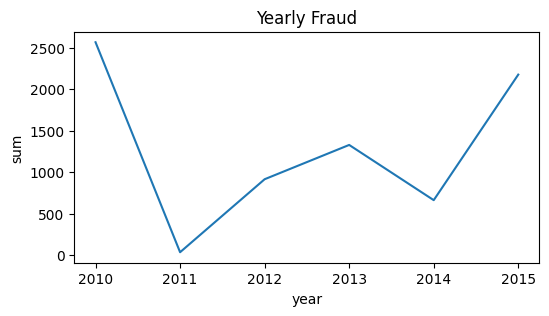

tx_year
2010    2566
2011      37
2012     916
2013    1329
2014     664
2015    2176
Name: fraud, dtype: int64

tx_year
2010    0.003095
2011    0.000043
2012    0.001038
2013    0.001471
2014    0.000729
2015    0.002349
Name: fraud, dtype: float64


In [ ]:
yearly_fraud = (
    df
    .groupby("tx_year")[LABEL]
    .sum()
)
plt.figure(figsize=(6,3))
yearly_fraud.plot()
plt.title("Yearly Fraud")
plt.xlabel("year")
plt.ylabel("sum")
plt.show()
print(yearly_fraud)
print()
yearly_fraud = (
    df
    .groupby("tx_year")[LABEL]
    .mean()
)
print(yearly_fraud)

### monthly fraud

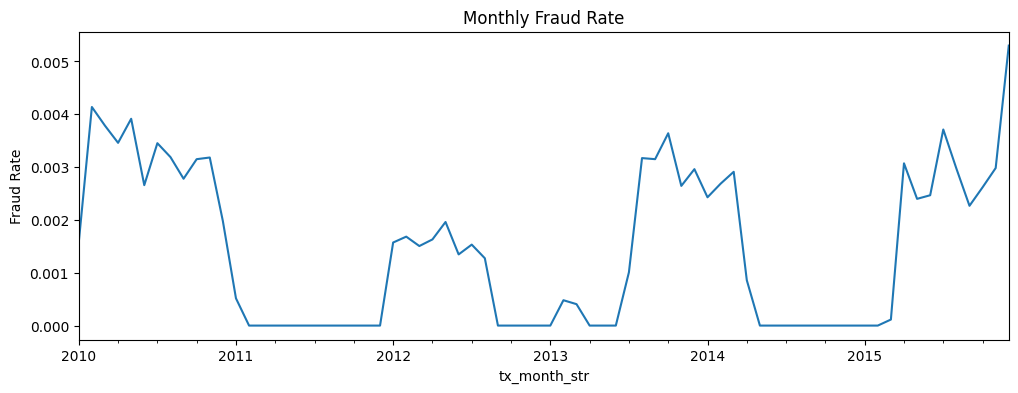

In [ ]:
monthly_fraud = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")[LABEL]
    .mean()
)

plt.figure(figsize=(12,4))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()

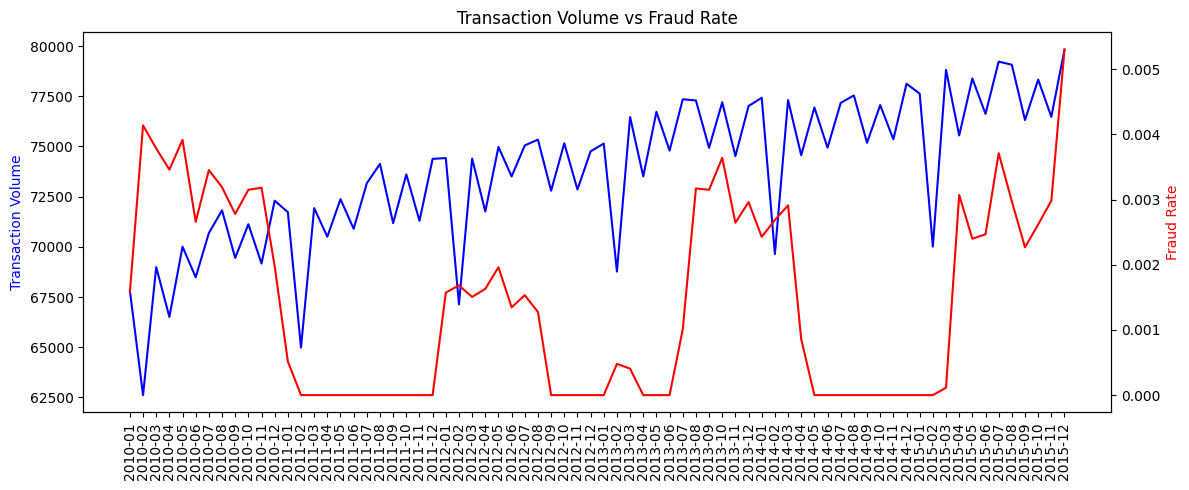

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(monthly_full["year_month"], monthly_full["count"], color="blue")
ax1.set_ylabel("Transaction Volume", color="blue")

ax2 = ax1.twinx()
ax2.plot(monthly_full["year_month"], monthly_full["mean"], color="red")
ax2.set_ylabel("Fraud Rate", color="red")

ax1.tick_params(axis='x', rotation=90)

plt.title("Transaction Volume vs Fraud Rate")
plt.tight_layout()
plt.show()


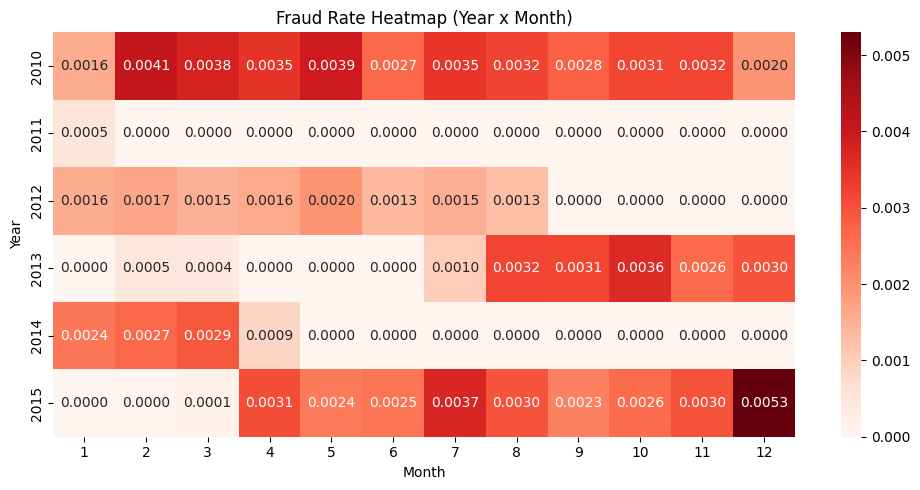

In [ ]:
pivot_df = (
    df.groupby(["tx_year", "tx_month"])[LABEL]
    .mean()
    .unstack()
)
plt.figure(figsize=(10, 5))
sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".4f",
    cmap="Reds"
)
plt.title("Fraud Rate Heatmap (Year x Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

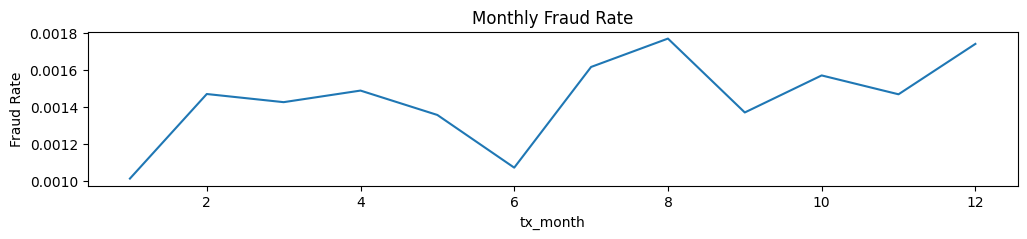

tx_month
1     0.001011
2     0.001468
3     0.001424
4     0.001487
5     0.001355
6     0.001070
7     0.001615
8     0.001768
9     0.001369
10    0.001569
11    0.001467
12    0.001740
Name: fraud, dtype: float64


In [ ]:
monthly_fraud = (
    df
    .groupby("tx_month")[LABEL]
    .mean()
)

plt.figure(figsize=(12,2))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()
print(monthly_fraud)


> **강한 계절성은 없다** 

### weekly fraud

weekday
6    0.002206
4    0.002016
0    0.001626
5    0.001280
1    0.001261
3    0.000920
2    0.000816
Name: fraud, dtype: float64


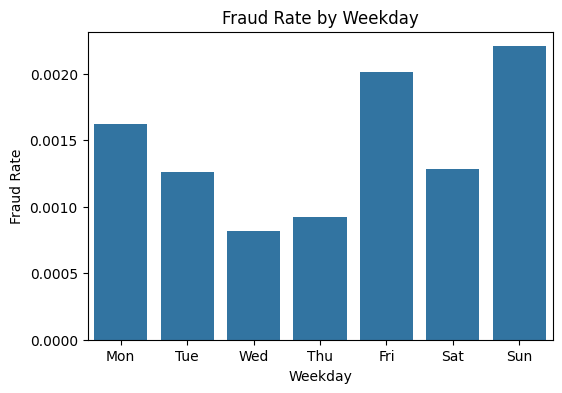

In [ ]:
weekday_rate = (
    df.groupby("weekday")["fraud"]
      .mean()
      .sort_values(ascending=False)
)

print(weekday_rate)

weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed",
    3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}

weekday_df = weekday_rate.reset_index()
weekday_df.columns = ["weekday", "fraud_rate"]

weekday_df["weekday_name"] = weekday_df["weekday"].map(weekday_map)

weekday_df = weekday_df.sort_values("weekday")

plt.figure(figsize=(6,4))
sns.barplot(data=weekday_df, x="weekday_name", y="fraud_rate")
plt.xlabel("Weekday")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Weekday")
plt.show()

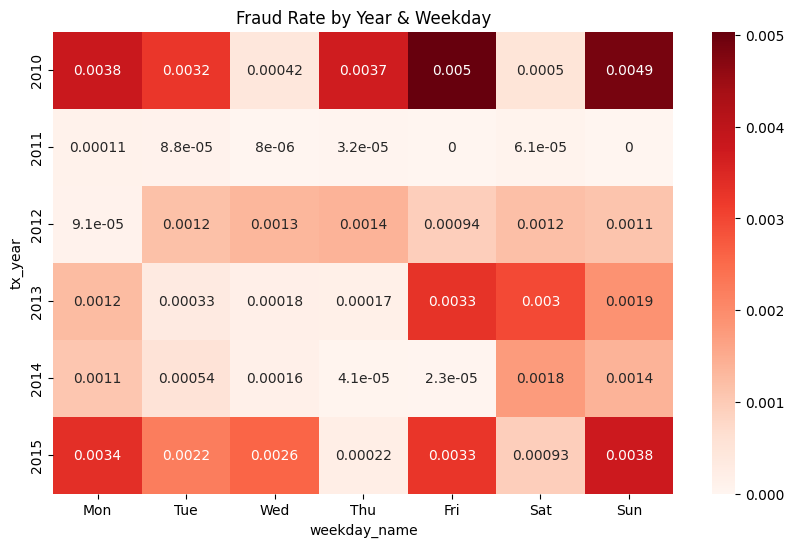

In [ ]:
df["weekday_name"] = df["date"].dt.day_name().str[:3]
pivot_weekday = (
    df.groupby(["tx_year", "weekday_name"])["fraud"]
      .mean()
      .unstack()
      .reindex(columns=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_weekday, cmap="Reds", annot=True)
plt.title("Fraud Rate by Year & Weekday")
plt.show()

> **약한 패턴** 

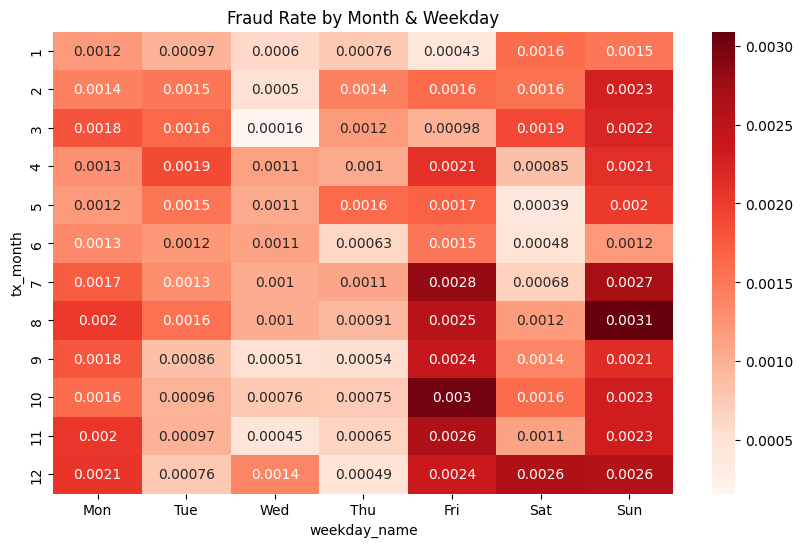

In [ ]:
pivot_weekday = (
    df.groupby(["tx_month", "weekday_name"])["fraud"]
      .mean()
      .unstack()
      .reindex(columns=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_weekday, cmap="Reds", annot=True)
plt.title("Fraud Rate by Month & Weekday")
plt.show()


> **month x weekday interaction**

### daily fraud

tx_day
1     0.001453
2     0.001441
3     0.001245
4     0.001392
5     0.001665
6     0.001592
7     0.001466
8     0.001322
9     0.001404
10    0.001262
11    0.001169
12    0.001605
13    0.001206
14    0.001278
15    0.001531
16    0.001320
17    0.001137
18    0.001647
19    0.001743
20    0.001306
21    0.001413
22    0.001447
23    0.001600
24    0.001233
25    0.001355
26    0.001650
27    0.001710
28    0.001658
29    0.001727
30    0.001367
31    0.001613
Name: fraud, dtype: float64


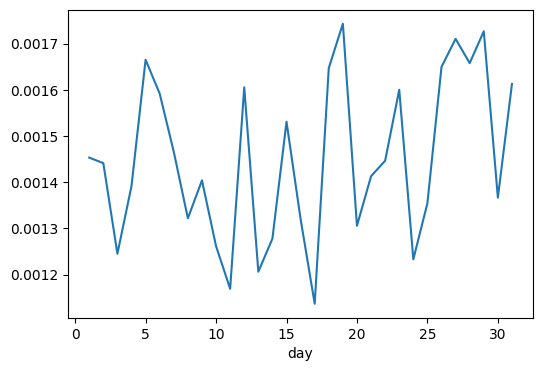

In [ ]:
day = (
    df
    .groupby("tx_day")[LABEL]
    .mean()
)

plt.figure(figsize=(6, 4))
day.plot()
plt.xlabel("day")
plt.ylabel("")

print(day)

### hourly fraud

tx_hour
0     0.000234
1     0.000824
2     0.000837
3     0.002465
4     0.002833
5     0.003024
6     0.001457
7     0.001398
8     0.001400
9     0.002283
10    0.002405
11    0.002170
12    0.001825
13    0.001988
14    0.001566
15    0.001433
16    0.001112
17    0.000821
18    0.000461
19    0.000533
20    0.000113
21    0.000125
22    0.000066
23    0.000333
Name: fraud, dtype: float64


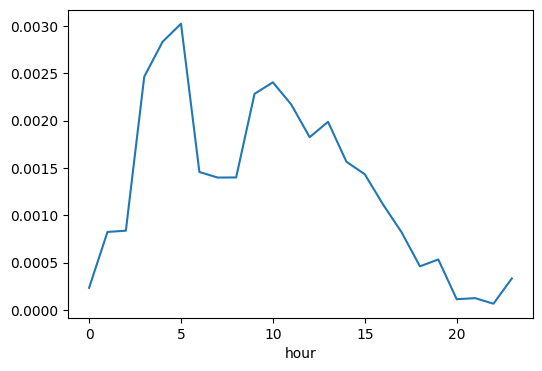

In [ ]:
hour = (
    df
    .groupby("tx_hour")[LABEL]
    .mean()
)

plt.figure(figsize=(6, 4))
hour.plot()
plt.xlabel("hour")
plt.ylabel("")

print(hour)

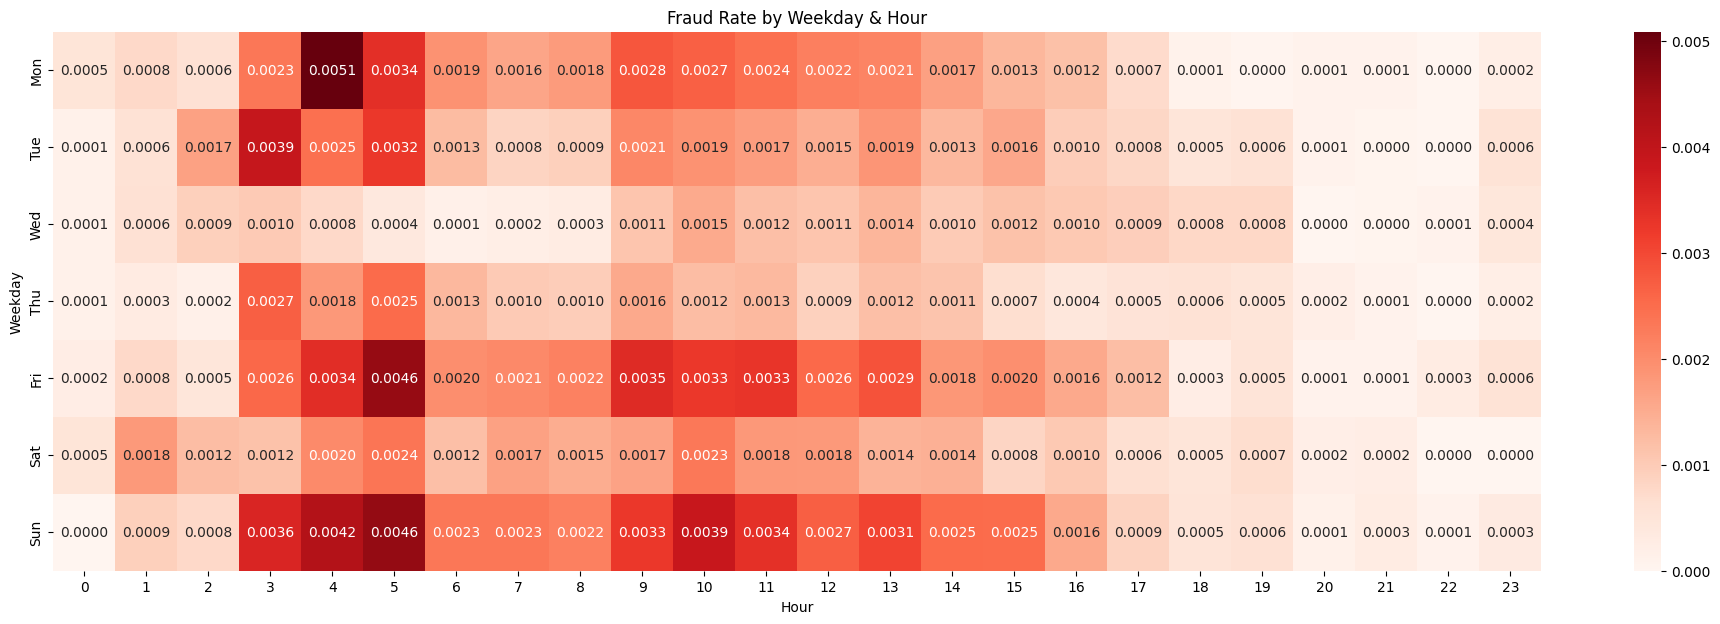

In [ ]:
pivot_weekday_hour = (
    df.groupby(["weekday_name", "tx_hour"])["fraud"]
      .mean()
      .unstack()  # hour가 column으로
      .reindex(index=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
)

plt.figure(figsize=(24,7))
sns.heatmap(
    pivot_weekday_hour,
    cmap="Reds",
    annot=True,
    fmt=".4f"
)
plt.title("Fraud Rate by Weekday & Hour")
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.show()

> **새벽 3~5시 = 강한 리스크 구간**

In [ ]:
df.drop("weekday_name", axis=1, inplace=True)

### hour sin / cos

In [ ]:
df["hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24).astype("float32")
df["hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24).astype("float32")

- **2011 drop 고려** 
- **2010, 2015는 High Risk Year**
- **7,8,12월이 높음** -> 계절성 패턴 가능성 
- **Fri, Sun 위험**

### 유의미성/효과
- Lift
- Stability
- Business Impact 
- Model Gain 

단변량 검증

In [ ]:
results = []

for col in ["tx_year",
            "tx_month",
            "tx_day",
            "tx_hour",
            "weekday",
            "hour_sin",
            "hour_cos"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,tx_year,-0.013787,0.986308,3.976901e-02
1,tx_month,0.025336,1.025660,2.487005e-14
2,tx_day,0.003928,1.003936,2.480725e-03
3,tx_hour,-0.061140,0.940691,1.764006e-157
4,weekday,0.073300,1.076053,1.927531e-37
5,hour_sin,0.412541,1.510652,6.178729e-139
6,hour_cos,-0.745041,0.474715,6.164731e-206


> hour sin

다변량 검증

In [ ]:
FEATURES = [
    "tx_year",
    "tx_month",
    "tx_day",
    "tx_hour",
    "weekday",
    "hour_sin",
    "hour_cos",
]

tmp = df[FEATURES + ["fraud"]].copy()
tmp = tmp.dropna(subset=FEATURES + ["fraud"])

X = sm.add_constant(tmp[FEATURES], has_constant="add")
y = tmp["fraud"].astype(int)

X = X.apply(pd.to_numeric, errors="raise")

model = sm.Logit(y, X).fit(disp=0)

res = pd.DataFrame({
    "feature": model.params.index,
    "coef": model.params.values,
    "OR": np.exp(model.params.values),
    "p_value": model.pvalues.values,
})

res["abs_coef"] = res["coef"].abs()
res = (
    res.sort_values(["p_value", "abs_coef"], ascending=[True, False])
      .drop(columns="abs_coef")
      .reset_index(drop=True)
)

display(res)
print(model.summary())

,feature,coef,OR,p_value
0,hour_cos,-0.826383,4.376294e-01,3.426331e-200
1,tx_hour,-0.099417,9.053650e-01,4.680035e-50
2,weekday,0.074610,1.077464e+00,9.427344e-39
3,tx_month,0.025087,1.025405e+00,4.481605e-14
4,tx_day,0.003734,1.003741e+00,4.021493e-03
5,hour_sin,-0.095211,9.091813e-01,1.264890e-02
6,tx_year,-0.015439,9.846800e-01,2.143613e-02
7,const,24.803775,5.917560e+10,6.631631e-02


                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312517
Method:                           MLE   Df Model:                            7
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                 0.01859
Time:                        09:32:12   Log-Likelihood:                -56870.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8038     13.508      1.836      0.066      -1.671      51.278
tx_year       -0.0154      0.007     -2.300      0.021      -0.029      -0.002
tx_month       0.0251      0.003      7.546      0.0

> **전체적으로 시간 단독 효과는 강하지 않다**

Lift

In [ ]:
y_pred = model.predict(X)
eval_df = pd.DataFrame({
    "fraud": y,
    "score": y_pred
})
eval_df["decile"] = pd.qcut(eval_df["score"], 10, labels=False)
lift_table = (
    eval_df
    .groupby("decile")["fraud"]
    .agg(["count", "sum", "mean"])
    .sort_index(ascending=False)
)

base_rate = eval_df["fraud"].mean()
lift_table["lift"] = lift_table["mean"] / base_rate

lift_table

,count,sum,mean,lift
decile,,,,
9,531136,1488,0.002802,1.935908
8,531351,1092,0.002055,1.420132
7,531096,949,0.001787,1.234755
6,531399,864,0.001626,1.123520
5,531218,917,0.001726,1.192845
4,531236,718,0.001352,0.933952
3,531329,667,0.001255,0.867461
2,531167,618,0.001163,0.803980
1,531287,299,0.000563,0.388893


1. 특정 feature 조합으로 로지스틱 학습

2. 예측 확률(score) 계산

3. score 기준 상위 10% 추출

4. 그 구간의 fraud rate 계산

5. baseline 대비 몇 배인지 계산 → lift

> 이 변수 조합이 fraud를 얼마나 위로 끌어올리는가

In [ ]:
def fit_logit_and_scores(df, features, y_col="fraud"):
    tmp = df[features + [y_col]].dropna(subset=features + [y_col]).copy()
    X = sm.add_constant(tmp[features], has_constant="add")
    y = tmp[y_col].astype(int)

    X = X.apply(pd.to_numeric, errors="raise")

    model = sm.Logit(y, X).fit(disp=0)
    score = model.predict(X)
    return model, y, score


def lift_table(y_true, score, n_bins=10):
    eval_df = pd.DataFrame({"y": y_true, "score": score}).copy()

    eval_df["bin"] = pd.qcut(eval_df["score"], q=n_bins, labels=False, duplicates="drop")

    base_rate = eval_df["y"].mean()

    tab = (
        eval_df.groupby("bin")["y"]
        .agg(count="count", sum="sum", mean="mean")
        .sort_index(ascending=False)
    )
    tab["lift"] = tab["mean"] / base_rate
    tab["base_rate"] = base_rate
    return tab

SPECS = {
    "tx_hour_only": ["tx_hour"],
    "weekday_only": ["weekday"],
    "hour_sin_cos_only": ["hour_sin", "hour_cos"],
    "tx_hour + weekday": ["tx_hour", "weekday"],
    "sin_cos + weekday": ["hour_sin", "hour_cos", "weekday"],
    "full_time_block": ["tx_year", "tx_month", "tx_day", "tx_hour", "weekday", "hour_sin", "hour_cos"],
}

lift_results = {}
models = {}

for name, feats in SPECS.items():
    model, y_aligned, score = fit_logit_and_scores(df, feats, y_col="fraud")
    models[name] = model
    lift_results[name] = lift_table(y_aligned, score, n_bins=10)

lift_results["full_time_block"]

,count,sum,mean,lift,base_rate
bin,,,,,
9,531136,1488,0.002802,1.935908,0.001447
8,531351,1092,0.002055,1.420132,0.001447
7,531096,949,0.001787,1.234755,0.001447
6,531399,864,0.001626,1.123520,0.001447
5,531218,917,0.001726,1.192845,0.001447
4,531236,718,0.001352,0.933952,0.001447
3,531329,667,0.001255,0.867461,0.001447
2,531167,618,0.001163,0.803980,0.001447
1,531287,299,0.000563,0.388893,0.001447


In [ ]:
summary = []
for name, tab in lift_results.items():
    top_bin = tab.index.max() 
    top_lift = tab.loc[top_bin, "lift"]
    top_rate = tab.loc[top_bin, "mean"]
    base_rate = tab.loc[top_bin, "base_rate"]
    summary.append([name, base_rate, top_rate, top_lift])

summary_df = pd.DataFrame(summary, columns=["model", "base_rate", "top_decile_rate", "top_decile_lift"]) \
               .sort_values("top_decile_lift", ascending=False) \
               .reset_index(drop=True)

summary_df

,model,base_rate,top_decile_rate,top_decile_lift
0,full_time_block,0.001447,0.002802,1.935908
1,sin_cos + weekday,0.001447,0.002775,1.917651
2,hour_sin_cos_only,0.001447,0.002405,1.661738
3,weekday_only,0.001447,0.002206,1.524424
4,tx_hour + weekday,0.001447,0.001766,1.220584
5,tx_hour_only,0.001447,0.001761,1.217166


> sin_cos + weekday가 거의 full이랑 동일\
-> year/month/day는 거의 기여 없음

> tx_hour_only는 1.21인데\
> hour_sin_cos_only는 1.66\
-> 원형 인코딩이 훨씬 잘 작동.


1. full_time_block 모델을 baseline으로 잡음

2. 한 개 feature 제거

3. 다시 학습

4. lift 감소폭 관찰

In [ ]:
FULL = SPECS["full_time_block"]

drop_tests = []
for drop_feat in FULL:
    feats = [f for f in FULL if f != drop_feat]
    model, y_aligned, score = fit_logit_and_scores(df, feats, y_col="fraud")
    tab = lift_table(y_aligned, score, n_bins=10)
    top_bin = tab.index.max()
    drop_tests.append([f"full_minus_{drop_feat}", tab.loc[top_bin, "lift"]])

drop_df = pd.DataFrame(drop_tests, columns=["model", "top_decile_lift"]) \
            .sort_values("top_decile_lift", ascending=False) \
            .reset_index(drop=True)

drop_df

,model,top_decile_lift
0,full_minus_tx_year,1.967303
1,full_minus_tx_hour,1.940988
2,full_minus_hour_sin,1.937177
3,full_minus_tx_day,1.933907
4,full_minus_tx_month,1.892133
5,full_minus_weekday,1.649505
6,full_minus_hour_cos,1.507636


**중요한 변수**
> weekday\
> hour_cos (시간의 원형 패턴)

**거의 의미 없는 변수**
> tx_year\
> tx_day\
> tx_month (border line)

### *-> hour_sin, cos 피처 추가 확정*

### ***summary***

> # Time Feature EDA 결과 정리  
> (FDS – Temporal Risk Block)
>
> ---
>
> ## 1. 분석 변수
>
> - `tx_year`
> - `tx_month`
> - `tx_day`
> - `tx_hour`
> - `weekday`
> - `hour_sin`
> - `hour_cos`
>
> Base fraud rate: **0.001447**
>
> ---
>
> # 2. 분포 관찰 요약
>
> ### (1) 연도별 거래 및 Fraud
>
> - 거래량은 연도별로 지속 증가
> - Fraud 건수는 변동성 존재
> - `tx_year` 계수 음(-)  
>   → 시간이 지날수록 fraud 비율은 완만히 감소
>
> ---
>
> ### (2) 월별 패턴
>
> - 7~12월 구간에서 상대적으로 높은 fraud rate 관찰
> - `tx_month` OR ≈ 1.025  
>   → 월이 증가할수록 소폭 상승
>
> 계절성 존재하나 강한 구조적 요인은 아님.
>
> ---
>
> ### (3) 요일 패턴
>
> - 금요일, 일요일 fraud rate 상대적으로 높음
> - 수요일 가장 낮음
> - `weekday` OR ≈ 1.07  
>   → 주 후반부 리스크 상승 경향
>
> ---
>
> ### (4) 시간대 패턴
>
> - 새벽 3~6시 구간에서 가장 높은 fraud rate
> - 오후 18~22시 구간 낮음
> - 단순 `tx_hour`는 음(-) 계수
> - `hour_sin`, `hour_cos` 사용 시 비선형 패턴 포착
>
> → Fraud는 명확한 **비선형 시간대 구조**를 가짐
>
> ---
>
> # 3. 단변량 로지스틱 결과
>
> | 변수 | OR | 해석 |
> |------|------|------|
> | weekday | 1.076 | 주 후반 리스크 증가 |
> | tx_month | 1.026 | 연말로 갈수록 증가 |
> | tx_day | 1.004 | 월 후반부 소폭 증가 |
> | tx_hour | 0.94 | 시간 증가 시 감소 경향 |
> | hour_sin | 1.51 | 주기성 신호 강함 |
> | hour_cos | 0.47 | 시간대 구조 강력 |
> | tx_year | 0.986 | 장기적으로 감소 |
>
> 시간 변수는 단순 선형보다 **주기성 표현이 중요**함을 확인.
>
> ---
>
> # 4. 다변량 로지스틱 결과
>
> | 변수 | OR | 방향 |
> |------|------|------|
> | hour_cos | 0.44 | ↓ (가장 강력) |
> | tx_hour | 0.91 | ↓ |
> | weekday | 1.08 | ↑ |
> | tx_month | 1.03 | ↑ |
> | tx_day | 1.00 | ↑ (미미) |
> | hour_sin | 0.91 | ↓ |
> | tx_year | 0.98 | ↓ |
>
> ### 핵심 해석
>
> - 시간대 효과는 `hour_cos`가 가장 강하게 설명
> - 요일 효과는 독립적으로 유지
> - 연/월/일은 보조적 조정 변수
>
> Pseudo R² = **0.0186**
>
> → 시간 블록 단독 설명력은 제한적
>
> ---
>
> # 5. Lift 분석
>
> | Decile | Fraud Rate | Lift |
> |--------|------------|------|
> | Top 10% | 0.002802 | 1.94 |
>
> → 시간 블록 단독 Lift ≈ **1.94**
>
> 금융 블록(Lift 4.26)에 비해 상대적으로 낮음.
>
> ---
>
> # 6. 모델 비교
>
> | 모델 | Lift |
> |------|------|
> | full_time_block | 1.94 |
> | sin_cos + weekday | 1.92 |
> | hour_sin_cos_only | 1.66 |
> | weekday_only | 1.52 |
> | tx_hour_only | 1.21 |
>
> ### 해석
>
> - 주기성(hour_sin, hour_cos) + weekday 조합이 핵심
> - 단순 tx_hour는 설명력 낮음
>
> ---
>
> # 7. Ablation 결과
>
> | 제거 변수 | Lift |
> |------------|------|
> | - hour_cos | 1.51 |
> | - weekday | 1.65 |
> | - tx_month | 1.89 |
> | - tx_hour | 1.94 |
>
> ### 결론
>
> `hour_cos`와 `weekday`가 시간 블록의 핵심 축.
>
> ---
>
> # 8. 종합 결론
>
> Temporal block의 리스크 구조는 다음과 같이 정리됨:
>
> ```
> 새벽 시간대 효과 (비선형)
> +
> 주 후반 효과
> +
> 연말 상승 경향
> ```
>
> - Fraud는 명확한 시간대 비선형 패턴을 가짐
> - 주기성 표현(sin/cos)이 단순 시간 변수보다 효과적
> - 단독 설명력은 제한적이나,  
>   다른 블록과 결합 시 리스크 보정 및 강화 역할 수행 가능

## Weekday History

- client_weekday_prev
- client_weekday_match_last1
- client_weekday_seen_last5
- client_weekday_prior_count
- client_weekday_is_new

---

## **Transaction Interval & Tempo Features**

## Interval Metrics
- seconds_since_prev_tx
- client_avg_interval_prev
- interval_ratio
- log_interval_dev

---

## **Velocity / Burst Detection**

## Volume Features

- client_tx_1h
- client_tx_1h_avg_prev
- velocity_spike_ratio
- card_tx_1h
- card_velocity_spike_ratio

---

## **Fraud History Features**

In [160]:
df["client_fraud_cum_prev"] = (
    df.groupby("client_id")["fraud"]
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype("int32")
)

In [161]:
df["card_fraud_cum_prev"] = (
    df.groupby("card_id")["fraud"]
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype("int32")
)

In [191]:
# client/card 누적 fraud bin (현재행 제외 기준)
df["client_fraud_hist_bin"] = pd.cut(
    df["client_fraud_cum_prev"],
    bins=[-1, 0, 1, 2, np.inf],
    labels=["0", "1", "2", "3+"]
)

df["card_fraud_hist_bin"] = pd.cut(
    df["card_fraud_cum_prev"],
    bins=[-1, 0, 1, 2, np.inf],
    labels=["0", "1", "2", "3+"]
)

In [162]:
df["client_fraud_last1"] = (
    df.groupby("client_id")["fraud"]
      .shift(1)
      .fillna(0)
      .astype("int8")
)

In [163]:
df["card_fraud_last1"] = (
    df.groupby("card_id")["fraud"]
      .shift(1)
      .fillna(0)
      .astype("int8")
)

In [164]:
f1 = df.groupby("client_id")["fraud"].shift(1)
f2 = df.groupby("client_id")["fraud"].shift(2)
f3 = df.groupby("client_id")["fraud"].shift(3)

df["client_fraud_last3"] = (
    f1.fillna(0).astype("int8") +
    f2.fillna(0).astype("int8") +
    f3.fillna(0).astype("int8")
)

In [165]:
f1 = df.groupby("card_id")["fraud"].shift(1)
f2 = df.groupby("card_id")["fraud"].shift(2)
f3 = df.groupby("card_id")["fraud"].shift(3)

df["card_fraud_last3"] = (
    f1.fillna(0).astype("int8") +
    f2.fillna(0).astype("int8") +
    f3.fillna(0).astype("int8")
)

In [166]:
df["client_has_fraud_history"] = (
    df["client_fraud_cum_prev"] > 0
).astype("int8")

In [167]:
df["card_has_fraud_history"] = (
    df["card_fraud_cum_prev"] > 0
).astype("int8")

단변량 검증

In [168]:
results = []

for col in ["client_fraud_cum_prev",
            "card_fraud_cum_prev",
            "client_fraud_last1",
            "client_fraud_last3",
            "client_has_fraud_history",
            "card_fraud_last1",
            "card_fraud_last3",
            "card_has_fraud_history"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,client_fraud_cum_prev,0.000893,1.000894,0.662293
1,card_fraud_cum_prev,0.002908,1.002912,0.406821
2,client_fraud_last1,7.465526,1746.774527,0.000000
3,client_fraud_last3,3.364251,28.911822,0.000000
4,client_has_fraud_history,-0.014710,0.985398,0.533877
5,card_fraud_last1,8.340968,4192.144547,0.000000
6,card_fraud_last3,3.454114,31.630267,0.000000
7,card_has_fraud_history,0.057840,1.059545,0.053146


다변량 검증

In [169]:
X = sm.add_constant(df[["client_fraud_cum_prev",
            "card_fraud_cum_prev",
            "client_fraud_last1",
            "client_fraud_last3",
            "client_has_fraud_history",
            "card_fraud_last1",
            "card_fraud_last3",
            "card_has_fraud_history"]].astype("float64"))

y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.004808
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312516
Method:                           MLE   Df Model:                            8
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                  0.5592
Time:                        18:03:30   Log-Likelihood:                -25544.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.6642      0.024   -324.249      0.000      -7.71

In [170]:
df.drop(columns=["client_fraud_last1", "client_fraud_last3", "card_fraud_last1", "card_fraud_last3"], inplace=True)

## Client & Card History

- client_fraud_cum_prev
- card_fraud_cum_prev
- client_fraud_last1
- client_fraud_last3
- client_has_fraud_history
- card_fraud_last1
- card_fraud_last3
- card_has_fraud_history

**has chip**

In [171]:
df["has_chip"].value_counts()

has_chip
1    4777420
0     535105
Name: count, dtype: int64

**card_type**

In [172]:
df["card_type"] = np.select(
    [
        df["is_credit"] == 1,
        df["is_prepaid"] == 1
    ],
    [
        "credit",
        "debit(prepaid)"
    ],
    default="debit(non_prepaid)"
)

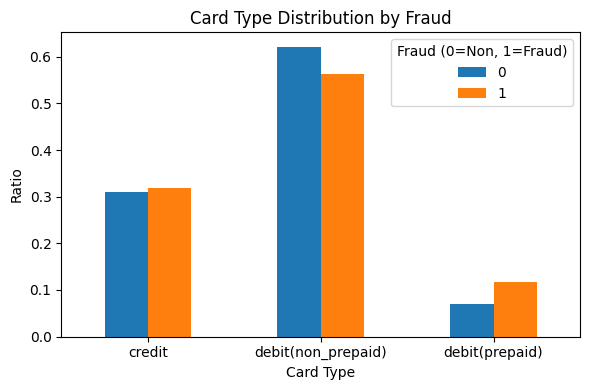

In [173]:
df["card_type"] = df["card_type"].astype("category")

card_ratio = (
    df.groupby("fraud")["card_type"]
      .value_counts(normalize=True)
      .unstack()
)

card_ratio.T.plot(kind="bar", figsize=(6,4))
plt.ylabel("Ratio")
plt.xlabel("Card Type")
plt.title("Card Type Distribution by Fraud")
plt.xticks(rotation=0)
plt.legend(title="Fraud (0=Non, 1=Fraud)")
plt.tight_layout()
plt.show()

In [174]:
fraud_rate = (
    df.groupby("card_type")["fraud"]
      .mean()
      .sort_values(ascending=False)
)
fraud_rate

/tmp/ipykernel_351666/1246485000.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("card_type")["fraud"]


card_type
debit(prepaid)        0.002438
credit                0.001494
debit(non_prepaid)    0.001313
Name: fraud, dtype: float64

*왜 prepaid가 더 높을까*

In [184]:
df["is_prepaid"] = (df["card_type"] == "debit(prepaid)").astype("int8")

amount x prepaid

Text(0, 0.5, '')

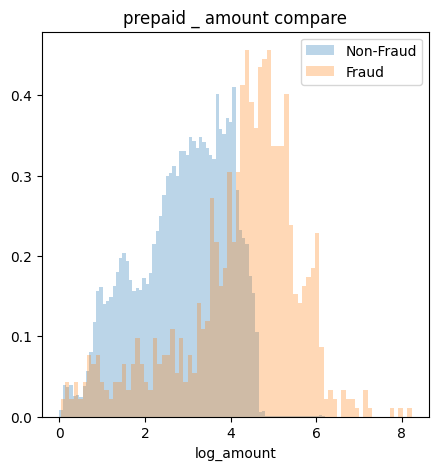

In [175]:
prepaid = df[df["card_type"]=="debit(prepaid)"].copy()

plt.figure(figsize=(5,5))
plt.hist(prepaid[prepaid["fraud"]==0]["log_abs_amount"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(prepaid[prepaid["fraud"]==1]["log_abs_amount"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("log_amount")
plt.title("prepaid _ amount compare")
plt.legend()
plt.ylabel("")

In [180]:
df["prepaid_logamount_interaction"] = (
    (df["card_type"] == "debit(prepaid)").astype(int)
    * df["log_abs_amount"]
)

mcc x prepaid

In [176]:
prepaid = df[df["card_type"] == "debit(prepaid)"].copy()

mcc_compare = (
    prepaid.groupby(["mcc", "fraud"])
           .size()
           .unstack(fill_value=0)
)

mcc_compare_ratio = mcc_compare.div(mcc_compare.sum(axis=1), axis=0)

mcc_compare_ratio.head()

fraud,0,1
mcc,,
1711,1.000000,0.000000
3000,0.166667,0.833333
3001,0.500000,0.500000
3005,0.000000,1.000000
3006,0.333333,0.666667


In [177]:
mcc_compare_ratio = mcc_compare_ratio.sort_values(by=1, ascending=False)

In [178]:
mcc_compare["total"] = mcc_compare.sum(axis=1)

mcc_filtered = mcc_compare[mcc_compare["total"] >= 50]

mcc_ratio = (
    mcc_filtered[[0,1]]
    .div(mcc_filtered["total"], axis=0)
    .sort_values(by=1, ascending=False)
)

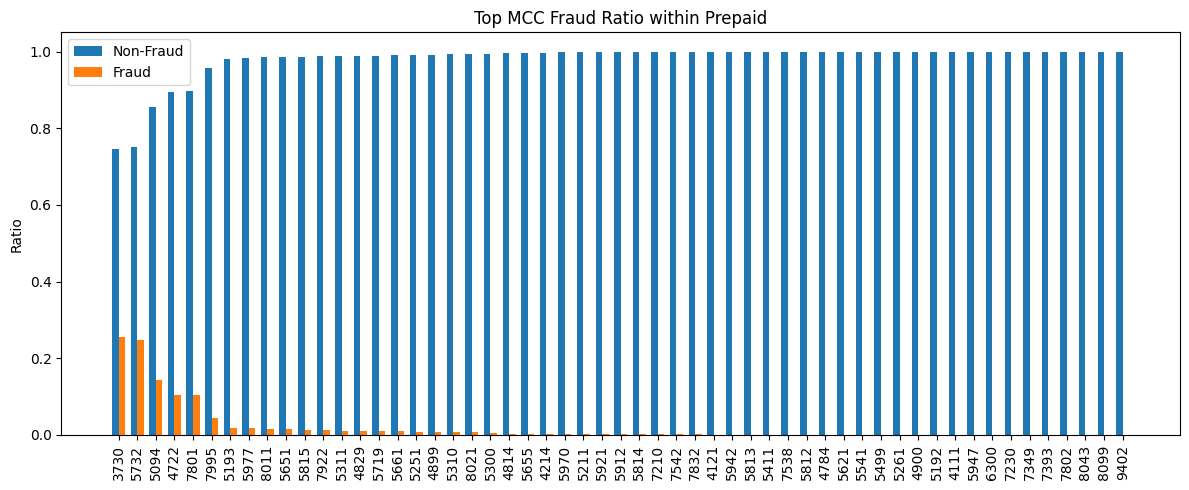

In [179]:
x = np.arange(len(mcc_ratio))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, mcc_ratio[0], width, label="Non-Fraud")
plt.bar(x + width/2, mcc_ratio[1], width, label="Fraud")

plt.xticks(x, mcc_ratio.index, rotation=90)
plt.ylabel("Ratio")
plt.title("Top MCC Fraud Ratio within Prepaid")
plt.legend()
plt.tight_layout()
plt.show()

3730: Ship Chandlers\
5732: Electronics Stores\
5094: Precious Stones and Metals\
4722: Travel Agencies\
7801: Athletic Fields, Commercial Sports

df["card_debit(non_prepaid)"] = df["card_debit(non_prepaid)"].astype("int8")
df["card_debit(prepaid)"] = df["card_debit(prepaid)"].astype("int8")

In [185]:
results = []

for col in ["prepaid_logamount_interaction",
            "is_prepaid"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,prepaid_logamount_interaction,0.298174,1.347396,2.533406e-221
1,is_prepaid,0.574956,1.777053,7.783182e-59


In [186]:
X = sm.add_constant(df[[
  "prepaid_logamount_interaction",
            "is_prepaid"
]])

y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.010696
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312522
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                 0.01946
Time:                        18:25:33   Log-Likelihood:                -56820.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -6.5891      0.012   -542.582      0

In [189]:
y_pred = model.predict(X)
eval_df = pd.DataFrame({
    "fraud": y,
    "score": y_pred
})
eval_df["decile"] = pd.qcut(eval_df["score"], 10, labels=False, duplicates="drop")
lift_table = (
    eval_df
    .groupby("decile")["fraud"]
    .agg(["count", "sum", "mean"])
    .sort_index(ascending=False)
)

base_rate = eval_df["fraud"].mean()
lift_table["lift"] = lift_table["mean"] / base_rate

lift_table

,count,sum,mean,lift
decile,,,,
1,139182,718,0.005159,3.564749
0,5173343,6970,0.001347,0.930999


---

## **Interaction Feature Analysis**

## Two-Way Interactions

- fraud_history × has_error
- mcc_is_new × has_error
- has_error × log_interval_dev
- mcc_is_new × velocity_spike_ratio
- amount_deviation × mcc_is_new
- amount_limit_ratio × has_error

## Three-Way Interactions

- mcc_is_new × has_error × velocity_spike_ratio
- fraud_history × has_error × velocity_spike_ratio
- merchant_is_new × mcc_is_new × has_error

---

## **Refund Segment Analysis**

- is_refund vs fraud rate
- refund × mcc_is_new
- refund × has_error
- refund × velocity_spike_ratio

In [154]:
df.groupby("is_refund")[LABEL].mean()

is_refund
0    0.001460
1    0.001194
Name: fraud, dtype: float64

In [155]:
df.groupby("fraud")["is_refund"].mean()

fraud
0    0.050128
1    0.041363
Name: is_refund, dtype: float64

refund & fraud 거래의 amount 분포

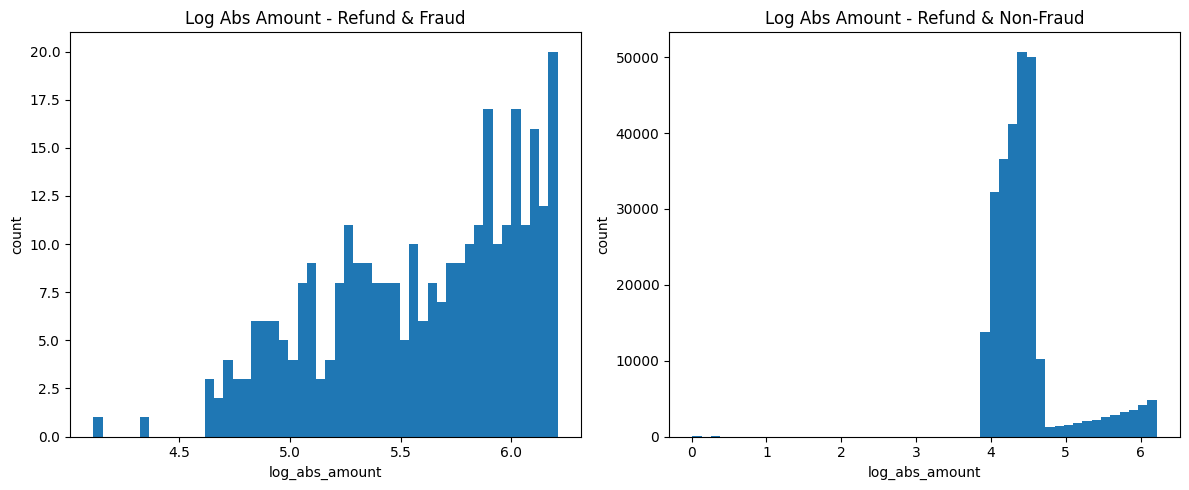

Mean amount (refund+fraud): -293.47485
Mean amount (refund+nonfraud): -102.138275


In [157]:
df_rf = df[(df["is_refund"] == 1) & (df["fraud"] == 1)]
df_rn = df[(df["is_refund"] == 1) & (df["fraud"] == 0)]

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(np.log1p(np.abs(df_rf["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(np.abs(df_rn["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Non-Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")

plt.tight_layout()
plt.show()

print("Mean amount (refund+fraud):", df_rf["amount"].mean())
print("Mean amount (refund+nonfraud):", df_rn["amount"].mean())


> refund & fraud는 고금액 쪽에 몰려 있음

In [158]:
thr = df["log_abs_amount"].quantile(0.9)
df["refund_high_amount"] = (
    (df["is_refund"] == 1) & (df["log_abs_amount"] > thr)
).astype("int8")

In [159]:
results = []

for col in ["is_refund",
            "refund_high_amount"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,is_refund,-0.201371,0.817609,4.417742e-04
1,refund_high_amount,1.954172,7.058073,5.797729e-246


---

## **Amount Deviation Analysis**

## Deviation Types

- amount_vs_client_avg_ratio
- amount_vs_client_avg_diff
- amount_vs_recent_window_avg
- amount_vs_client_quantile (q95/q99)

## Interaction

- amount_deviation × mcc_is_new
- amount_deviation × velocity_spike_ratio
- amount_deviation × has_error

---